In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn import datasets
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker, NiftiLabelsMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats

# Homemade functions

In [2]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [3]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [4]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [5]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [6]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])
        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass


def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"
    rROI = "Right_" + ROI
    rROI_r1 = "Right_" + ROI + "_r1"
    rROI_r2 = "Right_" + ROI + "_r2"
    lROI = "Left_" + ROI
    lROI_r1 = "Left_" + ROI + "_r1"
    lROI_r2 = "Left_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            values_Right_ROI_array = np.array(values_Right_ROI).T
            values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant],
                                                                                       lROI: values_Left_ROI_array[:, current_participant], 
                                                                                       rROI: values_Right_ROI_array[:, current_participant]}
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)
                label_left = np.repeat(lROI, 15)
                label_right = np.repeat(rROI, 15)
                roi_labels = [label_bi, label_left, label_right]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_left = values_Left_ROI_array[:, current_participant]
                current_participant_right = values_Right_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

                for x in range(3):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI, lROI: averageLeft_ROI, rROI: averageRight_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]
    Right_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r1) for sub_id in subjects_list]
    Right_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], rROI_r2) for sub_id in subjects_list]
    Left_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r1) for sub_id in subjects_list]
    Left_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], lROI_r2) for sub_id in subjects_list]    

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]
    Right_ROI_raw_r1_list = [x for x in Right_ROI_raw_r1_list if x is not None]
    Right_ROI_raw_r2_list = [x for x in Right_ROI_raw_r2_list if x is not None]
    Left_ROI_raw_r1_list = [x for x in Left_ROI_raw_r1_list if x is not None]
    Left_ROI_raw_r2_list = [x for x in Left_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)
    Right_ROI_raw_r1_average = np.mean(Right_ROI_raw_r1_list, axis=0)
    Right_ROI_raw_r2_average = np.mean(Right_ROI_raw_r2_list, axis=0)
    Left_ROI_raw_r1_average = np.mean(Left_ROI_raw_r1_list, axis=0)
    Left_ROI_raw_r2_average = np.mean(Left_ROI_raw_r2_list, axis=0)

    # Create TR array.
    TRs_raw = np.arange(0, 378, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average, Right_ROI_raw_r1_average, Right_ROI_raw_r2_average, Left_ROI_raw_r1_average, Left_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2, rROI_r1, rROI_r2, lROI_r1, lROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(6):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)

        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_6860/1498170635.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):


In [7]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [8]:
# Create narrow_z.
# I was using the whole time-series to z-score and find outliers (< 3 std). However, there might be too noise in the whole time-series.
# Hence, making it difficult to find the outliers in the time where trailers are presented. For this reason, I will create a new z-scored
# time-series using only the time where trailers are presented.

# Create function to get the z-scored time-series for each ROI in the first run.
def get_narrow_z_timeseries_r1(sub_dict):

    # Create list with the trailers from run 1.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    
    # Create a list to store the timecourses for each ROI.
    NAcc_data_list = []
    AIns_data_list = []
    MPFC_data_list = []
    
    # Loop through each trailer and get the timecourse for each ROI.
    for id_trailer in range(len(r1_keys)):
            
            # Append the timecourse for each ROI to the list.
            NAcc_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_NAcc"])
            AIns_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_AIns"])
            MPFC_data_list.append(sub_dict[r1_keys[id_trailer]]["Bilateral_MPFC"])

    # Convert lists to arrays.
    NAcc_data = np.array(NAcc_data_list).flatten()
    AIns_data = np.array(AIns_data_list).flatten()
    MPFC_data = np.array(MPFC_data_list).flatten()

    # Z-score the timecourses.
    NAcc_z = zscore(NAcc_data)
    AIns_z = zscore(AIns_data)
    MPFC_z = zscore(MPFC_data)

    # Transform back into dictionary.
    Sub_z_dict = {}

    # Create a runner variable to loop through the z-scored timecourses.
    runner = 0

    # Loop through each trailer and get the z-scored timecourse for each ROI.
    for id_trailer in range(len(r1_keys)):

        # Create a dictionary to store the z-scored timecourse for each ROI.
        current_trailer_dict = {} 

        # Append the z-scored timecourse for each ROI to the dictionary. 
        current_trailer_dict["Bilateral_NAcc"] = NAcc_z[runner:runner+15]
        current_trailer_dict["Bilateral_AIns"] = AIns_z[runner:runner+15]
        current_trailer_dict["Bilateral_MPFC"] = MPFC_z[runner:runner+15]

        # Append the z-scored timecourse for each ROI to the dictionary.
        Sub_z_dict[r1_keys[id_trailer]] = current_trailer_dict

        # Update the runner variable.
        runner += 15

    return Sub_z_dict

# Create function to get the z-scored time-series for each ROI in the second run.
def get_narrow_z_timeseries_r2(sub_dict):

    # Create list with the trailers from run 2.
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']
    
    # Create a list to store the timecourses for each ROI.
    NAcc_data_list = []
    AIns_data_list = []
    MPFC_data_list = []
    
    # Loop through each trailer and get the timecourse for each ROI.
    for id_trailer in range(len(r2_keys)):
            
            # Append the timecourse for each ROI to the list.
            NAcc_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_NAcc"])
            AIns_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_AIns"])
            MPFC_data_list.append(sub_dict[r2_keys[id_trailer]]["Bilateral_MPFC"])

    # Convert lists to arrays.
    NAcc_data = np.array(NAcc_data_list).flatten()
    AIns_data = np.array(AIns_data_list).flatten()
    MPFC_data = np.array(MPFC_data_list).flatten()

    # Z-score the timecourses.
    NAcc_z = zscore(NAcc_data)
    AIns_z = zscore(AIns_data)
    MPFC_z = zscore(MPFC_data)

    # Transform back into dictionary.
    Sub_z_dict = {}

    # Create a runner variable to loop through the z-scored timecourses.
    runner = 0

    # Loop through each trailer and get the z-scored timecourse for each ROI.
    for id_trailer in range(len(r2_keys)):

        # Create a dictionary to store the z-scored timecourse for each ROI.
        current_trailer_dict = {} 

        # Append the z-scored timecourse for each ROI to the dictionary. 
        current_trailer_dict["Bilateral_NAcc"] = NAcc_z[runner:runner+15]
        current_trailer_dict["Bilateral_AIns"] = AIns_z[runner:runner+15]
        current_trailer_dict["Bilateral_MPFC"] = MPFC_z[runner:runner+15]

        # Append the z-scored timecourse for
        Sub_z_dict[r2_keys[id_trailer]] = current_trailer_dict

        # Update the runner variable.
        runner += 15

    return Sub_z_dict


In [9]:
# Load cortical and sub-cortical HO atlas. 
cortical_atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr50-2mm")
cortical_atlas_maps = cortical_atlas.maps
cortical_atlas_labels = cortical_atlas.labels

subcortical_atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr50-2mm")
subcortical_atlas_maps = subcortical_atlas.maps
subcortical_atlas_labels = subcortical_atlas.labels


def getROIs_timecourse(participant_num, sub_motion): 

    # Add code to flag if something that is not a number is passed. 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run2_onsets = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id]
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id]

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1
        #run1_trailer_onsets[int(run1_current_trailer_onset + 5):int(run1_current_trailer_onset)+ 30 + 5] = 1
        #run2_trailer_onsets[int(run2_current_trailer_onset + 5):int(run2_current_trailer_onset)+ 30 + 5] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "tcompcor"] 
    # ["white_matter", "csf", "csf_wm", "framewise_displacement",  "rmsd", "tcompcor"]
    
    cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02',
                       'w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1'
                       ,'trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
                       'trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2',
                       'trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2',
                       'rot_y_derivative1_power2','rot_z_derivative1_power2','cosine00'] #, 'c_comp_cor_03', 'c_comp_cor_04'

    """
    Check if ISC scores improve with motion event covariates
    """
    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] #"motion"
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_confounds = [i for i in sub_run1_confounds_df.columns if "motion" in i] #"motion"
    sub_run2_motion_confounds = [i for i in sub_run2_confounds_df.columns if "motion" in i] 

    sub_run1_cohen_confounds_df = sub_run1_confounds_df[cohen_confounds ] #+ sub_run1_motion_s_confounds
    sub_run2_cohen_confounds_df = sub_run2_confounds_df[cohen_confounds ] #+ sub_run2_motion_s_confounds

    # Change NaNs to 0s. 
    sub_run1_cohen_confounds_df = sub_run1_cohen_confounds_df.fillna(0) 
    sub_run2_cohen_confounds_df = sub_run2_cohen_confounds_df.fillna(0) 

    # Specify the parameters to apply to the given analysis.

    detrend = False #True # False
    standardize = "zscore"
    standardize_confounds = "zscore" #False #type
    sphere_radius = 8 # from 6 to 8
    confounds1 = sub_run1_cohen_confounds_df
    confounds2 = sub_run2_cohen_confounds_df
    smoothing= 4 # from 6 to 4
    
    #
    
    ## 4) Apply mask to func data. 
    masker_HO_Cortical_ROI_r1 =  NiftiLabelsMasker(
        labels_img=cortical_atlas_maps,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )
    
    masker_HO_Subcortical_ROI_r1 = NiftiLabelsMasker(
        labels_img=subcortical_atlas_maps,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run1_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )

    masker_HO_Cortical_ROI_r2 = NiftiLabelsMasker(
        labels_img=cortical_atlas_maps,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )
    
    masker_HO_Subcortical_ROI_r2 = NiftiLabelsMasker(
        labels_img=subcortical_atlas_maps,
        allow_overlap=True,
        smoothing_fwhm=smoothing, # Applying a Gaussian filter with a 4mm kernel
        detrend=detrend,
        radius=sphere_radius, 
        mask_img=sub_run2_mask_path,
        standardize=standardize, 
        t_r=2,
        standardize_confounds=standardize_confounds,
        high_pass=1/360, # High cutoff frequency in Hertz. # Try 0.011
        #low_pass=0.1 # from 1.0
        )
    

    ROI_raw_timecourses = {}
    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    ## Add if statement to only apply the masker if the run has acceptable motion parameters. 

    if((sub_motion[0] < 1) and (sub_motion[1] < 1)):

        # Apply function to get the percent signal change from each ROI timecourse. 
        sub_r1_Cortical_ROI = masker_HO_Cortical_ROI_r1.fit_transform(sub_run1_func_path, confounds=confounds1)
        sub_r1_Subcortical_ROI = masker_HO_Subcortical_ROI_r1.fit_transform(sub_run1_func_path, confounds=confounds1)


        ## 5) Get the timecourses from each movie trailer. 
        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run1_timeseries = {}

        # Get the trailers presented in each run. 
        r1_keys = list(run1_onsets.keys())

        # Loop through each trailer and get its corresponding ROI timecourse
        for id in range(len(r1_keys)):

            run1_timeseries[r1_keys[id]] = {
                # Save cortical timecourses.
                'Frontal_Pole': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                'Insular_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                'Superior_Frontal_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                'Middle_Frontal_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                'IFG_pars_triangularis': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4],
                'IFG_pars_opercularis': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                'Precentral_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 6],
                'Temporal_Pole': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 7],
                'STG_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 8],
                'STG_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 9],
                'MTG_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 10],
                'MTG_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 11],
                'MTG_temporooccipital': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 12],
                'ITG_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 13],
                'ITG_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 14],
                'ITG_temporooccipital': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 15],
                'Postcentral_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 16],
                'Superior_Parietal_Lobule': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 17],
                'SG_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 18],
                'SG_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 19],
                'Angular_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 20],
                'LOC_superior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 21],
                'LOC_inferior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 22],
                'Intracalcarine_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 23],
                'Frontal_Medial_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 24],
                'Juxtapositional_Lobule_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 25],
                'Subcallosal_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 26],
                'Paracingulate_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 27],
                'Cingulate_Gyrus_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 28],
                'Cingulate_Gyrus_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 29],
                'Precuneous_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 30],
                'Cuneal_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 31],
                'Frontal_Orbital_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 32],
                'Parahippocampal_Gyrus_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 33],
                'Parahippocampal_Gyrus_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 34],
                'Lingual_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 35],
                'TFC_anterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 36],
                'TFC_posterior': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 37],
                'TOFC': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 38],
                'Occipital_Fusiform_Gyrus': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 39],
                'Frontal_Opercular_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 40],
                'Central_Opercular_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 41],
                'Parietal_Opercular_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 42],
                'Planum_Polare': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 43],
                "Heschls_Gyrus": sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 44],
                'Planum_Temporale': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 45],
                'Supracalcarine_Cortex': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 46],
                'Occipital_Pole': sub_r1_Cortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 47],

                # Save subcortical timecourses.
                'Left_Thalamus': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                'Left_Caudate': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                'Left_Putamen': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
                'Left_Pallidum': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
                'Brain_Stem': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4],
                'Left_Hippocampus': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
                'Left_Amygdala': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 6],
                'Left_Accumbens': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 7],
                'Right_Thalamus': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 11],
                'Right_Caudate': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 12],
                'Right_Putamen': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 13],
                'Right_Pallidum': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 14],
                'Right_Hippocampus': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 15],
                'Right_Amygdala': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 16],
                'Right_Accumbens': sub_r1_Subcortical_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 17]
            } 
                
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Frontal_Pole_r1"] = sub_r1_Cortical_ROI[:, 0]
        ROI_raw_timecourses["Insular_Cortex_r1"] = sub_r1_Cortical_ROI[:, 1]
        ROI_raw_timecourses["Superior_Frontal_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 2]
        ROI_raw_timecourses["Middle_Frontal_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 3]
        ROI_raw_timecourses["Inferior_Frontal_Gyrus_triang_r1"] = sub_r1_Cortical_ROI[:, 4]
        ROI_raw_timecourses["Inferior_Frontal_Gyrus_operc_r1"] = sub_r1_Cortical_ROI[:, 5]
        ROI_raw_timecourses["Precentral_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 6]
        ROI_raw_timecourses["Temporal_Pole_r1"] = sub_r1_Cortical_ROI[:, 7]
        ROI_raw_timecourses["Superior_Temporal_Gyrus_ant_r1"] = sub_r1_Cortical_ROI[:, 8]
        ROI_raw_timecourses["Superior_Temporal_Gyrus_post_r1"] = sub_r1_Cortical_ROI[:, 9]
        ROI_raw_timecourses["Middle_Temporal_Gyrus_ant_r1"] = sub_r1_Cortical_ROI[:, 10]
        ROI_raw_timecourses["Middle_Temporal_Gyrus_post_r1"] = sub_r1_Cortical_ROI[:, 11]
        ROI_raw_timecourses["Middle_Temporal_Gyrus_temp_r1"] = sub_r1_Cortical_ROI[:, 12]
        ROI_raw_timecourses["Inferior_Temporal_Gyrus_ant_r1"] = sub_r1_Cortical_ROI[:, 13]
        ROI_raw_timecourses["Inferior_Temporal_Gyrus_post_r1"] = sub_r1_Cortical_ROI[:, 14] 
        ROI_raw_timecourses["Inferior_Temporal_Gyrus_temp_r1"] = sub_r1_Cortical_ROI[:, 15]
        ROI_raw_timecourses["Postcentral_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 16]
        ROI_raw_timecourses["Superior_Parietal_Lobule_r1"] = sub_r1_Cortical_ROI[:, 17]
        ROI_raw_timecourses["Supramarginal_Gyrus_ant_r1"] = sub_r1_Cortical_ROI[:, 18]
        ROI_raw_timecourses["Supramarginal_Gyrus_post_r1"] = sub_r1_Cortical_ROI[:, 19]
        ROI_raw_timecourses["Angular_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 20]
        ROI_raw_timecourses["Lateral_Occipital_Cortex_sup_r1"] = sub_r1_Cortical_ROI[:, 21]
        ROI_raw_timecourses["Lateral_Occipital_Cortex_inf_r1"] = sub_r1_Cortical_ROI[:, 22]
        ROI_raw_timecourses["Intracalcarine_Cortex_r1"] = sub_r1_Cortical_ROI[:, 23]
        ROI_raw_timecourses["Frontal_Medial_Cortex_r1"] = sub_r1_Cortical_ROI[:, 24]
        ROI_raw_timecourses["Juxtapositional_Lobule_Cortex_r1"] = sub_r1_Cortical_ROI[:, 25]
        ROI_raw_timecourses["Subcallosal_Cortex_r1"] = sub_r1_Cortical_ROI[:, 26]
        ROI_raw_timecourses["Paracingulate_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 27]
        ROI_raw_timecourses["Cingulate_Gyrus_ant_r1"] = sub_r1_Cortical_ROI[:, 28]
        ROI_raw_timecourses["Cingulate_Gyrus_post_r1"] = sub_r1_Cortical_ROI[:, 29]
        ROI_raw_timecourses["Precuneous_Cortex_r1"] = sub_r1_Cortical_ROI[:, 30]
        ROI_raw_timecourses["Cuneal_Cortex_r1"] = sub_r1_Cortical_ROI[:, 31]
        ROI_raw_timecourses["Frontal_Orbital_Cortex_r1"] = sub_r1_Cortical_ROI[:, 32]
        ROI_raw_timecourses["Parahippocampal_Gyrus_ant_r1"] = sub_r1_Cortical_ROI[:, 33]
        ROI_raw_timecourses["Parahippocampal_Gyrus_post_r1"] = sub_r1_Cortical_ROI[:, 34]
        ROI_raw_timecourses["Lingual_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 35]
        ROI_raw_timecourses["Temporal_Fusiform_Cortex_ant_r1"] = sub_r1_Cortical_ROI[:, 36]
        ROI_raw_timecourses["Temporal_Fusiform_Cortex_post_r1"] = sub_r1_Cortical_ROI[:, 37]
        ROI_raw_timecourses["Temporal_Occipital_Fusiform_Cortex_r1"] = sub_r1_Cortical_ROI[:, 38]
        ROI_raw_timecourses["Occipital_Fusiform_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 39]
        ROI_raw_timecourses["Frontal_Opercular_Cortex_r1"] = sub_r1_Cortical_ROI[:, 40]
        ROI_raw_timecourses["Central_Opercular_Cortex_r1"] = sub_r1_Cortical_ROI[:, 41]
        ROI_raw_timecourses["Parietal_Opercular_Cortex_r1"] = sub_r1_Cortical_ROI[:, 42]
        ROI_raw_timecourses["Planum_Polare_r1"] = sub_r1_Cortical_ROI[:, 43]
        ROI_raw_timecourses["Heschl's_Gyrus_r1"] = sub_r1_Cortical_ROI[:, 44]
        ROI_raw_timecourses["Planum_Temporale_r1"] = sub_r1_Cortical_ROI[:, 45]
        ROI_raw_timecourses["Supracalcarine_Cortex_r1"] = sub_r1_Cortical_ROI[:, 46]
        ROI_raw_timecourses["Occipital_Pole_r1"] = sub_r1_Cortical_ROI[:, 47]
        ROI_raw_timecourses["Left_Thalamus_r1"] = sub_r1_Subcortical_ROI[:, 0]
        ROI_raw_timecourses["Left_Caudate_r1"] = sub_r1_Subcortical_ROI[:, 1]
        ROI_raw_timecourses["Left_Putamen_r1"] = sub_r1_Subcortical_ROI[:, 2]
        ROI_raw_timecourses["Left_Pallidum_r1"] = sub_r1_Subcortical_ROI[:, 3]
        ROI_raw_timecourses["Brain-Stem_r1"] = sub_r1_Subcortical_ROI[:, 4]
        ROI_raw_timecourses["Left_Hippocampus_r1"] = sub_r1_Subcortical_ROI[:, 5]
        ROI_raw_timecourses["Left_Amygdala_r1"] = sub_r1_Subcortical_ROI[:, 6]
        ROI_raw_timecourses["Left_Accumbens_r1"] = sub_r1_Subcortical_ROI[:, 7]
        ROI_raw_timecourses["Right_Thalamus_r1"] = sub_r1_Subcortical_ROI[:, 11]
        ROI_raw_timecourses["Right_Caudate_r1"] = sub_r1_Subcortical_ROI[:, 12]
        ROI_raw_timecourses["Right_Putamen_r1"] = sub_r1_Subcortical_ROI[:, 13]
        ROI_raw_timecourses["Right_Pallidum_r1"] = sub_r1_Subcortical_ROI[:, 14]
        ROI_raw_timecourses["Right_Hippocampus_r1"] = sub_r1_Subcortical_ROI[:, 15]
        ROI_raw_timecourses["Right_Amygdala_r1"] = sub_r1_Subcortical_ROI[:, 16]
        ROI_raw_timecourses["Right_Accumbens_r1"] = sub_r1_Subcortical_ROI[:, 17]



   

    # Apply for second run.
    if((sub_motion[2] < 1) and (sub_motion[3] < 1)):

        # Apply function to get the percent signal change from each ROI timecourse.
        sub_r2_Cortical_ROI = masker_HO_Cortical_ROI_r2.fit_transform(sub_run2_func_path, confounds=confounds2)
        sub_r2_Subcortical_ROI = masker_HO_Subcortical_ROI_r2.fit_transform(sub_run2_func_path, confounds=confounds2)

        # Create dictionary variable to store arrays with time series arrays for each trailer.
        run2_timeseries = {}

        r2_keys = list(run2_onsets.keys())

        # Loop through each traile and get its corresponding ROI timecourse
        for id in range(len(r2_keys)):
            run2_timeseries[r2_keys[id]] = {
                # Save cortical timecourses.
                "Frontal_Pole": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Insular_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Superior_Frontal_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Middle_Frontal_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "IFG_pars_triangularis": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4],
                "IFG_pars_opercularis": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Precentral_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 6],
                "Temporal_Pole": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 7],
                "STG_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 8],
                "STG_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 9],
                "MTG_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 10],
                "MTG_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 11],
                "MTG_temporooccipital": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 12],
                "ITG_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 13],
                "ITG_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 14],
                "ITG_temporooccipital": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 15],
                "Postcentral_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 16],
                "Superior_Parietal_Lobule": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 17],
                "SG_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 18],
                "SG_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 19],
                "Angular_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 20],
                "LOC_superior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 21],
                "LOC_inferior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 22],
                "Intracalcarine_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 23],
                "Frontal_Medial_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 24],
                "Juxtapositional_Lobule_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 25],
                "Subcallosal_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 26],
                "Paracingulate_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 27],
                "Cingulate_Gyrus_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 28],
                "Cingulate_Gyrus_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 29],
                "Precuneous_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 30],
                "Cuneal_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 31],
                "Frontal_Orbital_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 32],
                "Parahippocampal_Gyrus_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 33],
                "Parahippocampal_Gyrus_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 34],
                "Lingual_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 35],
                "TFC_anterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 36],
                "TFC_posterior": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 37],
                "TOFC": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 38],
                "Occipital_Fusiform_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 39],
                "Frontal_Opercular_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 40],
                "Central_Opercular_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 41],
                "Parietal_Opercular_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 42],
                "Planum_Polare": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 43],
                "Heschls_Gyrus": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 44],
                "Planum_Temporale": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 45],
                "Supracalcarine_Cortex": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 46],
                "Occipital_Pole": sub_r2_Cortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 47],

                # Save subcortical timecourses.
                "Left_Thalamus": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Left_Caudate": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Left_Putamen": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
                "Left_Pallidum": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
                "Brain_Stem": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4],
                "Left_Hippocampus": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
                "Left_Amygdala": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 6],
                "Left_Accumbens": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 7],
                "Right_Thalamus": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 11],
                "Right_Caudate": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 12],
                "Right_Putamen": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 13],
                "Right_Pallidum": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 14],
                "Right_Hippocampus": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 15],
                "Right_Amygdala": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 16],
                "Right_Accumbens": sub_r2_Subcortical_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 17]       
                }
        
        # This code gives me the un-trimmed timecourses for each ROI.
        ROI_raw_timecourses["Frontal_Pole_r2"] = sub_r2_Cortical_ROI[:, 0]
        ROI_raw_timecourses["Insular_Cortex_r2"] = sub_r2_Cortical_ROI[:, 1]
        ROI_raw_timecourses["Superior_Frontal_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 2]
        ROI_raw_timecourses["Middle_Frontal_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 3]
        ROI_raw_timecourses["Inferior_Frontal_Gyrus_triang_r2"] = sub_r2_Cortical_ROI[:, 4]
        ROI_raw_timecourses["Inferior_Frontal_Gyrus_operc_r2"] = sub_r2_Cortical_ROI[:, 5]
        ROI_raw_timecourses["Precentral_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 6]
        ROI_raw_timecourses["Temporal_Pole_r2"] = sub_r2_Cortical_ROI[:, 7]
        ROI_raw_timecourses["Superior_Temporal_Gyrus_ant_r2"] = sub_r2_Cortical_ROI[:, 8]
        ROI_raw_timecourses["Superior_Temporal_Gyrus_post_r2"] = sub_r2_Cortical_ROI[:, 9]
        ROI_raw_timecourses["Middle_Temporal_Gyrus_ant_r2"] = sub_r2_Cortical_ROI[:, 10]
        ROI_raw_timecourses["Middle_Temporal_Gyrus_post_r2"] = sub_r2_Cortical_ROI[:, 11]
        ROI_raw_timecourses["Middle_Temporal_Gyrus_temp_r2"] = sub_r2_Cortical_ROI[:, 12]
        ROI_raw_timecourses["Inferior_Temporal_Gyrus_ant_r2"] = sub_r2_Cortical_ROI[:, 13]
        ROI_raw_timecourses["Inferior_Temporal_Gyrus_post_r2"] = sub_r2_Cortical_ROI[:, 14]
        ROI_raw_timecourses["Inferior_Temporal_Gyrus_temp_r2"] = sub_r2_Cortical_ROI[:, 15]
        ROI_raw_timecourses["Postcentral_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 16]
        ROI_raw_timecourses["Superior_Parietal_Lobule_r2"] = sub_r2_Cortical_ROI[:, 17]
        ROI_raw_timecourses["Supramarginal_Gyrus_ant_r2"] = sub_r2_Cortical_ROI[:, 18]
        ROI_raw_timecourses["Supramarginal_Gyrus_post_r2"] = sub_r2_Cortical_ROI[:, 19]
        ROI_raw_timecourses["Angular_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 20]
        ROI_raw_timecourses["Lateral_Occipital_Cortex_sup_r2"] = sub_r2_Cortical_ROI[:, 21]
        ROI_raw_timecourses["Lateral_Occipital_Cortex_inf_r2"] = sub_r2_Cortical_ROI[:, 22]
        ROI_raw_timecourses["Intracalcarine_Cortex_r2"] = sub_r2_Cortical_ROI[:, 23]
        ROI_raw_timecourses["Frontal_Medial_Cortex_r2"] = sub_r2_Cortical_ROI[:, 24]
        ROI_raw_timecourses["Juxtapositional_Lobule_Cortex_r2"] = sub_r2_Cortical_ROI[:, 25]
        ROI_raw_timecourses["Subcallosal_Cortex_r2"] = sub_r2_Cortical_ROI[:, 26]
        ROI_raw_timecourses["Paracingulate_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 27]
        ROI_raw_timecourses["Cingulate_Gyrus_ant_r2"] = sub_r2_Cortical_ROI[:, 28]
        ROI_raw_timecourses["Cingulate_Gyrus_post_r2"] = sub_r2_Cortical_ROI[:, 29]
        ROI_raw_timecourses["Precuneous_Cortex_r2"] = sub_r2_Cortical_ROI[:, 30]
        ROI_raw_timecourses["Cuneal_Cortex_r2"] = sub_r2_Cortical_ROI[:, 31]
        ROI_raw_timecourses["Frontal_Orbital_Cortex_r2"] = sub_r2_Cortical_ROI[:, 32]
        ROI_raw_timecourses["Parahippocampal_Gyrus_ant_r2"] = sub_r2_Cortical_ROI[:, 33]
        ROI_raw_timecourses["Parahippocampal_Gyrus_post_r2"] = sub_r2_Cortical_ROI[:, 34]
        ROI_raw_timecourses["Lingual_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 35]
        ROI_raw_timecourses["Temporal_Fusiform_Cortex_ant_r2"] = sub_r2_Cortical_ROI[:, 36]
        ROI_raw_timecourses["Temporal_Fusiform_Cortex_post_r2"] = sub_r2_Cortical_ROI[:, 37]
        ROI_raw_timecourses["Temporal_Occipital_Fusiform_Cortex_r2"] = sub_r2_Cortical_ROI[:, 38]
        ROI_raw_timecourses["Occipital_Fusiform_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 39]
        ROI_raw_timecourses["Frontal_Opercular_Cortex_r2"] = sub_r2_Cortical_ROI[:, 40]
        ROI_raw_timecourses["Central_Opercular_Cortex_r2"] = sub_r2_Cortical_ROI[:, 41]
        ROI_raw_timecourses["Parietal_Opercular_Cortex_r2"] = sub_r2_Cortical_ROI[:, 42]
        ROI_raw_timecourses["Planum_Polare_r2"] = sub_r2_Cortical_ROI[:, 43]
        ROI_raw_timecourses["Heschl's_Gyrus_r2"] = sub_r2_Cortical_ROI[:, 44]
        ROI_raw_timecourses["Planum_Temporale_r2"] = sub_r2_Cortical_ROI[:, 45]
        ROI_raw_timecourses["Supracalcarine_Cortex_r2"] = sub_r2_Cortical_ROI[:, 46]
        ROI_raw_timecourses["Occipital_Pole_r2"] = sub_r2_Cortical_ROI[:, 47]
        ROI_raw_timecourses["Left_Thalamus_r2"] = sub_r2_Subcortical_ROI[:, 0]
        ROI_raw_timecourses["Left_Caudate_r2"] = sub_r2_Subcortical_ROI[:, 1]
        ROI_raw_timecourses["Left_Putamen_r2"] = sub_r2_Subcortical_ROI[:, 2]
        ROI_raw_timecourses["Left_Pallidum_r2"] = sub_r2_Subcortical_ROI[:, 3]
        ROI_raw_timecourses["Brain-Stem_r2"] = sub_r2_Subcortical_ROI[:, 4]
        ROI_raw_timecourses["Left_Hippocampus_r2"] = sub_r2_Subcortical_ROI[:, 5]
        ROI_raw_timecourses["Left_Amygdala_r2"] = sub_r2_Subcortical_ROI[:, 6]
        ROI_raw_timecourses["Left_Accumbens_r2"] = sub_r2_Subcortical_ROI[:, 7]
        ROI_raw_timecourses["Right_Thalamus_r2"] = sub_r2_Subcortical_ROI[:, 11]
        ROI_raw_timecourses["Right_Caudate_r2"] = sub_r2_Subcortical_ROI[:, 12]
        ROI_raw_timecourses["Right_Putamen_r2"] = sub_r2_Subcortical_ROI[:, 13]
        ROI_raw_timecourses["Right_Pallidum_r2"] = sub_r2_Subcortical_ROI[:, 14]
        ROI_raw_timecourses["Right_Hippocampus_r2"] = sub_r2_Subcortical_ROI[:, 15]
        ROI_raw_timecourses["Right_Amygdala_r2"] = sub_r2_Subcortical_ROI[:, 16]
        ROI_raw_timecourses["Right_Accumbens_r2"] = sub_r2_Subcortical_ROI[:, 17]

    ## 6) Merge timecourses and events data. 
    if((sub_motion[0] < 1) and (sub_motion[2] < 1)): 

        # Merge the timecourses for both runs.
        all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries)   
        sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)

    elif((sub_motion[0] < 1) and (sub_motion[2] > 1)): 
        
        # Only data for first run. 
        all_timeseries = run1_timeseries
        sub_all_p_events = sub_run1_p_events
    elif((sub_motion[0] > 1) and (sub_motion[2] < 1)):

        # Only data for second run.
        all_timeseries = run2_timeseries
        sub_all_p_events = sub_run2_p_events
    else:
        all_timeseries = {}
        sub_all_p_events = []


    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses
    }
        
    return Output_dic



## Load and check Harvard Oxford cortical and sub-cortical brain atlases.


Atlas labels are: ['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Corte

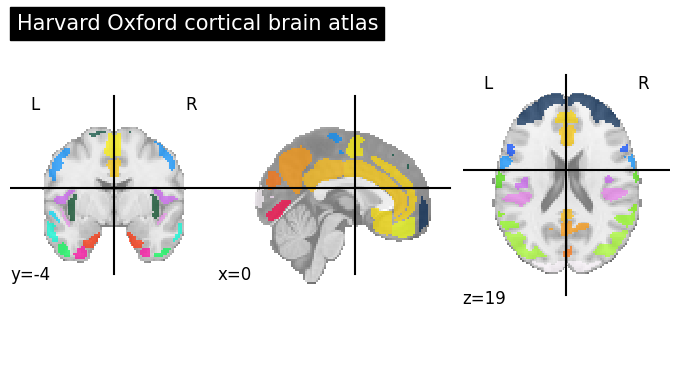

In [10]:

cortical_atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr50-2mm")
cortical_atlas_maps = cortical_atlas.maps
cortical_atlas_labels = cortical_atlas.labels

plot_roi(cortical_atlas.filename, title="Harvard Oxford cortical brain atlas")
print(f"Atlas labels are: {cortical_atlas_labels}")



In [32]:
np.unique(subcortical_atlas_maps.get_fdata()[25, : , :])

array([0., 1., 2.])

Atlas labels are: ['Background', 'Left Cerebral White Matter', 'Left Cerebral Cortex', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']


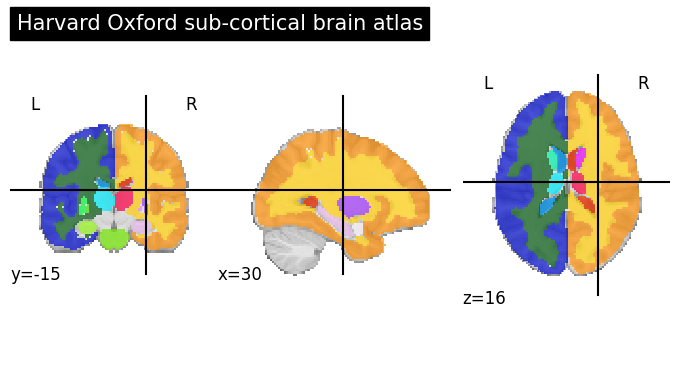

In [11]:

subcortical_atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr50-2mm")
subcortical_atlas_maps = subcortical_atlas.maps
subcortical_atlas_labels = subcortical_atlas.labels

plot_roi(subcortical_atlas.filename, title="Harvard Oxford sub-cortical brain atlas")
print(f"Atlas labels are: {subcortical_atlas_labels}")

In [12]:
# Test parcelation with 1 subject.
# sub1_path = "/Users/luisalvarez/Documents/Datasets/MovieData_BIDS_preproc/sub-01/func/sub-01_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

# cortical_masker =  NiftiLabelsMasker(
#     labels_img=subcortical_atlas_maps,
#     standardize="zscore_sample",
#     standardize_confounds="zscore_sample",
#     memory="nilearn_cache",
#     verbose=5,
# )

# time_series_test = cortical_masker.fit_transform(sub1_path)

# Get inter-subject correlation (ISC). 

In [13]:
# Define each subject motion parameters from fMRIprep.
# The first value is the max framewise displacement, the second is the mean framewise displacement.
# Two values per run. 
sub01_motion = [0.911, 0.095, 0.571, 0.077]
sub02_motion = [0.663, 0.073, 0.734, 0.108]
sub03_motion = [0.456, 0.048, 0.300, 0.049]
sub04_motion = [0.607, 0.080, 0.519, 0.076]
sub05_motion = [1.612, 0.138, 1.403, 0.208]
sub06_motion = [3.008, 0.248, 4.225, 0.311]
sub07_motion = [8.275, 0.156, 0.531, 0.072]
sub08_motion = [0.597, 0.074, 0.482, 0.072]
sub09_motion = [0.367, 0.069, 0.475, 0.104]
sub10_motion = [0.597, 0.074, 0.679, 0.103]
sub11_motion = [0.540, 0.059, 0.394, 0.055]
sub12_motion = [0.649, 0.154, 0.529, 0.162]
sub13_motion = [0.468, 0.091, 0.459, 0.102]
sub14_motion = [2.538, 0.164, 1.245, 0.091]
sub15_motion = [0.844, 0.066, 1.163, 0.062]
sub16_motion = [0.688, 0.111, 3.026, 0.218]
sub17_motion = [0.626, 0.091, 0.376, 0.072]
sub18_motion = [0.777, 0.054, 0.699, 0.048]
sub19_motion = [1.593, 0.180, 0.789, 0.189]
sub20_motion = [1.476, 0.091, 5.681, 0.167]
sub21_motion = [0.935, 0.088, 0.856, 0.110]
sub22_motion = [0.729, 0.084, 1.021, 0.105]
sub23_motion = [0.582, 0.084, 0.496, 0.073] # head looks a bit weird
sub24_motion = [1.406, 0.109, 1.550, 0.088]
sub25_motion = [0.649, 0.092, 0.351, 0.059]
sub26_motion = [0.894, 0.105, 0.965, 0.127]
sub27_motion = [0.525, 0.081, 0.494, 0.070]
sub28_motion = [1.001, 0.103, 0.494, 0.094]
sub29_motion = [0.300, 0.052, 0.330, 0.052]
sub30_motion = [0.269, 0.063, 0.335, 0.068]
sub31_motion = [0.398, 0.066, 0.377, 0.075]
sub32_motion = [0.817, 0.113, 1.551, 0.153]
sub33_motion = [0.959, 0.120, 0.627, 0.107]
sub34_motion = [0.344, 0.058, 0.309, 0.051]
sub35_motion = [0.656, 0.064, 0.704, 0.071]
sub36_motion = [0.790, 0.107, 0.746, 0.105]
sub37_motion = [0.560, 0.071, 0.585, 0.086]

participants_motion_list = [sub01_motion, sub02_motion, sub03_motion, sub04_motion, sub05_motion, sub06_motion, sub07_motion, sub08_motion, sub09_motion, sub10_motion, sub11_motion, sub12_motion, sub13_motion, sub14_motion, sub15_motion, sub16_motion, sub17_motion, sub18_motion, sub19_motion, sub20_motion, sub21_motion, sub22_motion, sub23_motion, sub24_motion, sub25_motion, sub26_motion, sub27_motion, sub28_motion, sub29_motion, sub30_motion, sub31_motion, sub32_motion, sub33_motion, sub34_motion, sub35_motion, sub36_motion, sub37_motion]

In [14]:

# Record the number with good data for each run. 
run1_subs_list = []
run2_subs_list = []
particpants_list = []

# Create relevant dictionaries. 
all_subjects_timecourses_z_dic = {}
participant_dictionaries_raw = {}
participants_events = {}

for sub_id in range(len(participants_motion_list)):
    
    # Format participant number.
    current_sub = "sub-" + str(sub_id + 1).zfill(2)
    current_num = str(sub_id + 1).zfill(2)

    # Get the timecourses for each participant.
    current_sub_dic = getROIs_timecourse(current_num, participants_motion_list[sub_id])

    # Print message to indicate that the participant has been processed.
    current_sub_motion_r1 = participants_motion_list[sub_id][0]
    current_sub_motion_r2 = participants_motion_list[sub_id][2]

    # Append data to relevant dictionaries. 
    # Append the participant number to the list of participants.
    if((current_sub_motion_r1 < 1) and (current_sub_motion_r2 < 1)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for BOTH runs.")
    elif((current_sub_motion_r1 < 1) and (current_sub_motion_r2 > 1)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run1_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_1 only.")
    elif((current_sub_motion_r1 > 1) and (current_sub_motion_r2 < 1)):
        all_subjects_timecourses_z_dic[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        run2_subs_list.append(current_sub)
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for RUN_2 only.")
    else:
        print("Participant " + current_sub + " has acceptable data for NONE of the runs.")

print("\nA total of " + str(len(run1_subs_list)) + " participants have acceptable data for RUN_1.")
print("A total of " + str(len(run2_subs_list)) + " participants have acceptable data for RUN_2.")
print("A total of " + str(len(particpants_list)) + " participants have usable data.")




KeyboardInterrupt: 

In [ ]:
participants_events["sub-01"].head()

,Trailer,Type,Onset,Offset,Duration,W_score,A_score,F_score,Pos_arousal,Neg_arousal,Pos_arousal_scaled,Neg_arousal_scaled,W_score_scaled
0,rh6,Horror,12,42,30,3,3,2,1.443547,0.391109,0.029333,0.391109,0.6875
1,uh1,Horror,60.0,90.0,30,1,3,3,1.706656,0.127999,0.292443,0.127999,-1.3125
2,rc2,Comedy,108.0,138.0,30,1,1,3,1.095104,-0.483553,-0.319109,-0.483553,-1.3125
3,rh2,Horror,152.0,182.0,30,3,2,2,1.137771,0.085333,-0.276443,0.085333,0.6875
4,rh1,Horror,196.0,226.0,30,4,3,2,1.443547,0.391109,0.029333,0.391109,1.6875


In [ ]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

In [ ]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [ ]:
all_subjects_timecourses_z_dic["sub-01"]["rh6"].keys()

dict_keys(['Frontal_Pole', 'Insular_Cortex', 'Superior_Frontal_Gyrus', 'Middle_Frontal_Gyrus', 'IFG_pars_triangularis', 'IFG_pars_opercularis', 'Precentral_Gyrus', 'Temporal_Pole', 'STG_anterior', 'STG_posterior', 'MTG_anterior', 'MTG_posterior', 'MTG_temporooccipital', 'ITG_anterior', 'ITG_posterior', 'ITG_temporooccipital', 'Postcentral_Gyrus', 'Superior_Parietal_Lobule', 'SG_anterior', 'SG_posterior', 'Angular_Gyrus', 'LOC_superior', 'LOC_inferior', 'Intracalcarine_Cortex', 'Frontal_Medial_Cortex', 'Juxtapositional_Lobule_Cortex', 'Subcallosal_Cortex', 'Paracingulate_Gyrus', 'Cingulate_Gyrus_anterior', 'Cingulate_Gyrus_posterior', 'Precuneous_Cortex', 'Cuneal_Cortex', 'Frontal_Orbital_Cortex', 'Parahippocampal_Gyrus_anterior', 'Parahippocampal_Gyrus_posterior', 'Lingual_Gyrus', 'TFC_anterior', 'TFC_posterior', 'TOFC', 'Occipital_Fusiform_Gyrus', 'Frontal_Opercular_Cortex', 'Central_Opercular_Cortex', 'Parietal_Opercular_Cortex', 'Planum_Polare', 'Heschls_Gyrus', 'Planum_Temporale', 

In [ ]:

# Create lists for r1 and r2 trailers. 
r1_trailers_list = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                  'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']

r2_trailers_list = ['rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'rh10', 'uc3', 'rh4',
                  'rc4', 'rh5', 'uc2', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']

# Create a dictionary with all the ISC for each participant.
all_subjects_isc_dic = {}

# Loop through each participant.
for id_sub in range(len(particpants_list)): 

    #current_sub = particpants_list[id_sub]
    current_sub = "sub-" + particpants_list[id_sub]
    current_sub_timecourses = {}
    print("Processing ISC for: " + current_sub)
    
    # Create new lists without the current participant for run 1 and run 2.
    # This is to calculate the mean timecourse for the group without the current participant.
    participant_list_filtered_run1 = run1_subs_list.copy()
    participant_list_filtered_run2 = run2_subs_list.copy()

    if current_sub in run1_subs_list:
        participant_list_filtered_run1.remove(current_sub)
    
    if current_sub in run2_subs_list:
        participant_list_filtered_run2.remove(current_sub)

    ### Separate run 1 and run 2. 
    # Loop through each trailer.
    if current_sub in run1_subs_list:    
        for id_trailer_r1 in range(len(r1_trailers_list)):

            # Create empty array to store the timecourses for the current trailer.
            # Accross all participants except the current participant. 
            
            current_trailer_timecourses_Frontal_Pole = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Insular_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Superior_Frontal_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Middle_Frontal_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_IFG_pars_triangularis = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_IFG_pars_opercularis = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Precentral_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Temporal_Pole = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_STG_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_STG_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_MTG_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_MTG_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_MTG_temporooccipital = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_ITG_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_ITG_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_ITG_temporooccipital = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Postcentral_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Superior_Parietal_Lobule = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_SG_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_SG_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Angular_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_LOC_superior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_LOC_inferior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Intracalcarine_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Frontal_Medial_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Juxtapositional_Lobule_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Subcallosal_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Paracingulate_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Cingulate_Gyrus_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Cingulate_Gyrus_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Precuneous_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Cuneal_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Frontal_Orbital_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Parahippocampal_Gyrus_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Parahippocampal_Gyrus_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Lingual_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_TFC_anterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_TFC_posterior = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_TOFC = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Occipital_Fusiform_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Frontal_Opercular_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Central_Opercular_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Parietal_Opercular_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Planum_Polare = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Heschls_Gyrus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Planum_Temporale = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Supracalcarine_Cortex = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Occipital_Pole = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Thalamus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Caudate = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Putamen = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Pallidum = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Brain_Stem = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Hippocampus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Amygdala = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Left_Accumbens = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Thalamus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Caudate = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Putamen = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Pallidum = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Hippocampus = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Amygdala = np.zeros((len(participant_list_filtered_run1), 15))
            current_trailer_timecourses_Right_Accumbens = np.zeros((len(participant_list_filtered_run1), 15))

            # Loop through each participant except the current participant.
            for id_sub2 in range(len(participant_list_filtered_run1)):

                current_sub2 = participant_list_filtered_run1[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_Frontal_Pole[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Frontal_Pole"]
                current_trailer_timecourses_Insular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Insular_Cortex"]
                current_trailer_timecourses_Superior_Frontal_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Superior_Frontal_Gyrus"]
                current_trailer_timecourses_Middle_Frontal_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Middle_Frontal_Gyrus"]
                current_trailer_timecourses_IFG_pars_triangularis[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["IFG_pars_triangularis"]
                current_trailer_timecourses_IFG_pars_opercularis[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["IFG_pars_opercularis"]
                current_trailer_timecourses_Precentral_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Precentral_Gyrus"]
                current_trailer_timecourses_Temporal_Pole[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Temporal_Pole"]
                current_trailer_timecourses_STG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["STG_anterior"]
                current_trailer_timecourses_STG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["STG_posterior"]
                current_trailer_timecourses_MTG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["MTG_anterior"]
                current_trailer_timecourses_MTG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["MTG_posterior"]
                current_trailer_timecourses_MTG_temporooccipital[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["MTG_temporooccipital"]
                current_trailer_timecourses_ITG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["ITG_anterior"]
                current_trailer_timecourses_ITG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["ITG_posterior"]
                current_trailer_timecourses_ITG_temporooccipital[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["ITG_temporooccipital"]
                current_trailer_timecourses_Postcentral_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Postcentral_Gyrus"]
                current_trailer_timecourses_Superior_Parietal_Lobule[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Superior_Parietal_Lobule"]
                current_trailer_timecourses_SG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["SG_anterior"]
                current_trailer_timecourses_SG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["SG_posterior"]
                current_trailer_timecourses_Angular_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Angular_Gyrus"]
                current_trailer_timecourses_LOC_superior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["LOC_superior"]
                current_trailer_timecourses_LOC_inferior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["LOC_inferior"]
                current_trailer_timecourses_Intracalcarine_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Intracalcarine_Cortex"]
                current_trailer_timecourses_Frontal_Medial_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Frontal_Medial_Cortex"]
                current_trailer_timecourses_Juxtapositional_Lobule_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Juxtapositional_Lobule_Cortex"]
                current_trailer_timecourses_Subcallosal_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Subcallosal_Cortex"]
                current_trailer_timecourses_Paracingulate_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Paracingulate_Gyrus"]
                current_trailer_timecourses_Cingulate_Gyrus_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Cingulate_Gyrus_anterior"]
                current_trailer_timecourses_Cingulate_Gyrus_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Cingulate_Gyrus_posterior"]
                current_trailer_timecourses_Precuneous_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Precuneous_Cortex"]
                current_trailer_timecourses_Cuneal_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Cuneal_Cortex"]
                current_trailer_timecourses_Frontal_Orbital_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Frontal_Orbital_Cortex"]
                current_trailer_timecourses_Parahippocampal_Gyrus_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Parahippocampal_Gyrus_anterior"]
                current_trailer_timecourses_Parahippocampal_Gyrus_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Parahippocampal_Gyrus_posterior"]
                current_trailer_timecourses_Lingual_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Lingual_Gyrus"]
                current_trailer_timecourses_TFC_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["TFC_anterior"]
                current_trailer_timecourses_TFC_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["TFC_posterior"]
                current_trailer_timecourses_TOFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["TOFC"]
                current_trailer_timecourses_Occipital_Fusiform_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Occipital_Fusiform_Gyrus"]
                current_trailer_timecourses_Frontal_Opercular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Frontal_Opercular_Cortex"]
                current_trailer_timecourses_Central_Opercular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Central_Opercular_Cortex"]
                current_trailer_timecourses_Parietal_Opercular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Parietal_Opercular_Cortex"]
                current_trailer_timecourses_Planum_Polare[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Planum_Polare"]
                current_trailer_timecourses_Heschls_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Heschls_Gyrus"]
                current_trailer_timecourses_Planum_Temporale[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Planum_Temporale"]
                current_trailer_timecourses_Supracalcarine_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Supracalcarine_Cortex"]
                current_trailer_timecourses_Occipital_Pole[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Occipital_Pole"]
                current_trailer_timecourses_Left_Thalamus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Thalamus"]
                current_trailer_timecourses_Left_Caudate[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Caudate"]
                current_trailer_timecourses_Left_Putamen[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Putamen"]
                current_trailer_timecourses_Left_Pallidum[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Pallidum"]
                current_trailer_timecourses_Brain_Stem[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Brain_Stem"]
                current_trailer_timecourses_Left_Hippocampus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Hippocampus"]
                current_trailer_timecourses_Left_Amygdala[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Amygdala"]
                current_trailer_timecourses_Left_Accumbens[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Left_Accumbens"]
                current_trailer_timecourses_Right_Thalamus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Thalamus"]
                current_trailer_timecourses_Right_Caudate[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Caudate"]
                current_trailer_timecourses_Right_Putamen[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Putamen"]
                current_trailer_timecourses_Right_Pallidum[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Pallidum"]
                current_trailer_timecourses_Right_Hippocampus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Hippocampus"]
                current_trailer_timecourses_Right_Amygdala[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Amygdala"]
                current_trailer_timecourses_Right_Accumbens[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r1_trailers_list[id_trailer_r1]]["Right_Accumbens"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_Frontal_Pole = np.mean(current_trailer_timecourses_Frontal_Pole, axis=0)
            mean_timecourse_Insular_Cortex = np.mean(current_trailer_timecourses_Insular_Cortex, axis=0)
            mean_timecourse_Superior_Frontal_Gyrus = np.mean(current_trailer_timecourses_Superior_Frontal_Gyrus, axis=0)
            mean_timecourse_Middle_Frontal_Gyrus = np.mean(current_trailer_timecourses_Middle_Frontal_Gyrus, axis=0)
            mean_timecourse_IFG_pars_triangularis = np.mean(current_trailer_timecourses_IFG_pars_triangularis, axis=0)
            mean_timecourse_IFG_pars_opercularis = np.mean(current_trailer_timecourses_IFG_pars_opercularis, axis=0)
            mean_timecourse_Precentral_Gyrus = np.mean(current_trailer_timecourses_Precentral_Gyrus, axis=0)
            mean_timecourse_Temporal_Pole = np.mean(current_trailer_timecourses_Temporal_Pole, axis=0)
            mean_timecourse_STG_anterior = np.mean(current_trailer_timecourses_STG_anterior, axis=0)
            mean_timecourse_STG_posterior = np.mean(current_trailer_timecourses_STG_posterior, axis=0)
            mean_timecourse_MTG_anterior = np.mean(current_trailer_timecourses_MTG_anterior, axis=0)
            mean_timecourse_MTG_posterior = np.mean(current_trailer_timecourses_MTG_posterior, axis=0)
            mean_timecourse_MTG_temporooccipital = np.mean(current_trailer_timecourses_MTG_temporooccipital, axis=0)
            mean_timecourse_ITG_anterior = np.mean(current_trailer_timecourses_ITG_anterior, axis=0)
            mean_timecourse_ITG_posterior = np.mean(current_trailer_timecourses_ITG_posterior, axis=0)
            mean_timecourse_ITG_temporooccipital = np.mean(current_trailer_timecourses_ITG_temporooccipital, axis=0)
            mean_timecourse_Postcentral_Gyrus = np.mean(current_trailer_timecourses_Postcentral_Gyrus, axis=0)
            mean_timecourse_Superior_Parietal_Lobule = np.mean(current_trailer_timecourses_Superior_Parietal_Lobule, axis=0)
            mean_timecourse_SG_anterior = np.mean(current_trailer_timecourses_SG_anterior, axis=0)
            mean_timecourse_SG_posterior = np.mean(current_trailer_timecourses_SG_posterior, axis=0)
            mean_timecourse_Angular_Gyrus = np.mean(current_trailer_timecourses_Angular_Gyrus, axis=0)
            mean_timecourse_LOC_superior = np.mean(current_trailer_timecourses_LOC_superior, axis=0)
            mean_timecourse_LOC_inferior = np.mean(current_trailer_timecourses_LOC_inferior, axis=0)
            mean_timecourse_Intracalcarine_Cortex = np.mean(current_trailer_timecourses_Intracalcarine_Cortex, axis=0)
            mean_timecourse_Frontal_Medial_Cortex = np.mean(current_trailer_timecourses_Frontal_Medial_Cortex, axis=0)
            mean_timecourse_Juxtapositional_Lobule_Cortex = np.mean(current_trailer_timecourses_Juxtapositional_Lobule_Cortex, axis=0)
            mean_timecourse_Subcallosal_Cortex = np.mean(current_trailer_timecourses_Subcallosal_Cortex, axis=0)
            mean_timecourse_Paracingulate_Gyrus = np.mean(current_trailer_timecourses_Paracingulate_Gyrus, axis=0)
            mean_timecourse_Cingulate_Gyrus_anterior = np.mean(current_trailer_timecourses_Cingulate_Gyrus_anterior, axis=0)
            mean_timecourse_Cingulate_Gyrus_posterior = np.mean(current_trailer_timecourses_Cingulate_Gyrus_posterior, axis=0)
            mean_timecourse_Precuneous_Cortex = np.mean(current_trailer_timecourses_Precuneous_Cortex, axis=0)
            mean_timecourse_Cuneal_Cortex = np.mean(current_trailer_timecourses_Cuneal_Cortex, axis=0)
            mean_timecourse_Frontal_Orbital_Cortex = np.mean(current_trailer_timecourses_Frontal_Orbital_Cortex, axis=0)
            mean_timecourse_Parahippocampal_Gyrus_anterior = np.mean(current_trailer_timecourses_Parahippocampal_Gyrus_anterior, axis=0)
            mean_timecourse_Parahippocampal_Gyrus_posterior = np.mean(current_trailer_timecourses_Parahippocampal_Gyrus_posterior, axis=0)
            mean_timecourse_Lingual_Gyrus = np.mean(current_trailer_timecourses_Lingual_Gyrus, axis=0)
            mean_timecourse_TFC_anterior = np.mean(current_trailer_timecourses_TFC_anterior, axis=0)
            mean_timecourse_TFC_posterior = np.mean(current_trailer_timecourses_TFC_posterior, axis=0)
            mean_timecourse_TOFC = np.mean(current_trailer_timecourses_TOFC, axis=0)
            mean_timecourse_Occipital_Fusiform_Gyrus = np.mean(current_trailer_timecourses_Occipital_Fusiform_Gyrus, axis=0)
            mean_timecourse_Frontal_Opercular_Cortex = np.mean(current_trailer_timecourses_Frontal_Opercular_Cortex, axis=0)
            mean_timecourse_Central_Opercular_Cortex = np.mean(current_trailer_timecourses_Central_Opercular_Cortex, axis=0)
            mean_timecourse_Parietal_Opercular_Cortex = np.mean(current_trailer_timecourses_Parietal_Opercular_Cortex, axis=0)
            mean_timecourse_Planum_Polare = np.mean(current_trailer_timecourses_Planum_Polare, axis=0)
            mean_timecourse_Heschls_Gyrus = np.mean(current_trailer_timecourses_Heschls_Gyrus, axis=0)
            mean_timecourse_Planum_Temporale = np.mean(current_trailer_timecourses_Planum_Temporale, axis=0)
            mean_timecourse_Supracalcarine_Cortex = np.mean(current_trailer_timecourses_Supracalcarine_Cortex, axis=0)
            mean_timecourse_Occipital_Pole = np.mean(current_trailer_timecourses_Occipital_Pole, axis=0)
            mean_timecourse_Left_Thalamus = np.mean(current_trailer_timecourses_Left_Thalamus, axis=0)
            mean_timecourse_Left_Caudate = np.mean(current_trailer_timecourses_Left_Caudate, axis=0)
            mean_timecourse_Left_Putamen = np.mean(current_trailer_timecourses_Left_Putamen, axis=0)
            mean_timecourse_Left_Pallidum = np.mean(current_trailer_timecourses_Left_Pallidum, axis=0)
            mean_timecourse_Brain_Stem = np.mean(current_trailer_timecourses_Brain_Stem, axis=0)
            mean_timecourse_Left_Hippocampus = np.mean(current_trailer_timecourses_Left_Hippocampus, axis=0)
            mean_timecourse_Left_Amygdala = np.mean(current_trailer_timecourses_Left_Amygdala, axis=0)
            mean_timecourse_Left_Accumbens = np.mean(current_trailer_timecourses_Left_Accumbens, axis=0)
            mean_timecourse_Right_Thalamus = np.mean(current_trailer_timecourses_Right_Thalamus, axis=0)
            mean_timecourse_Right_Caudate = np.mean(current_trailer_timecourses_Right_Caudate, axis=0)
            mean_timecourse_Right_Putamen = np.mean(current_trailer_timecourses_Right_Putamen, axis=0)
            mean_timecourse_Right_Pallidum = np.mean(current_trailer_timecourses_Right_Pallidum, axis=0)
            mean_timecourse_Right_Hippocampus = np.mean(current_trailer_timecourses_Right_Hippocampus, axis=0)
            mean_timecourse_Right_Amygdala = np.mean(current_trailer_timecourses_Right_Amygdala, axis=0)
            mean_timecourse_Right_Accumbens = np.mean(current_trailer_timecourses_Right_Accumbens, axis=0)

            # Calculate the ISC for the current trailer for the current participant.
            # Store correlation value regardless of significance.
            current_sub_timecourses[r1_trailers_list[id_trailer_r1]] = {"Frontal_Pole_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Frontal_Pole"], mean_timecourse_Frontal_Pole)[0]),
                                                                        "Insular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Insular_Cortex"], mean_timecourse_Insular_Cortex)[0]),
                                                                        "Superior_Frontal_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Superior_Frontal_Gyrus"], mean_timecourse_Superior_Frontal_Gyrus)[0]),
                                                                        "Middle_Frontal_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Middle_Frontal_Gyrus"], mean_timecourse_Middle_Frontal_Gyrus)[0]),
                                                                        "IFG_pars_triangularis_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["IFG_pars_triangularis"], mean_timecourse_IFG_pars_triangularis)[0]),
                                                                        "IFG_pars_opercularis_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["IFG_pars_opercularis"], mean_timecourse_IFG_pars_opercularis)[0]),
                                                                        "Precentral_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Precentral_Gyrus"], mean_timecourse_Precentral_Gyrus)[0]),
                                                                        "Temporal_Pole_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Temporal_Pole"], mean_timecourse_Temporal_Pole)[0]),
                                                                        "STG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["STG_anterior"], mean_timecourse_STG_anterior)[0]),
                                                                        "STG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["STG_posterior"], mean_timecourse_STG_posterior)[0]),
                                                                        "MTG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["MTG_anterior"], mean_timecourse_MTG_anterior)[0]),
                                                                        "MTG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["MTG_posterior"], mean_timecourse_MTG_posterior)[0]),
                                                                        "MTG_temporooccipital_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["MTG_temporooccipital"], mean_timecourse_MTG_temporooccipital)[0]),
                                                                        "ITG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["ITG_anterior"], mean_timecourse_ITG_anterior)[0]),
                                                                        "ITG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["ITG_posterior"], mean_timecourse_ITG_posterior)[0]),
                                                                        "ITG_temporooccipital_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["ITG_temporooccipital"], mean_timecourse_ITG_temporooccipital)[0]),
                                                                        "Postcentral_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Postcentral_Gyrus"], mean_timecourse_Postcentral_Gyrus)[0]),
                                                                        "Superior_Parietal_Lobule_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Superior_Parietal_Lobule"], mean_timecourse_Superior_Parietal_Lobule)[0]),
                                                                        "SG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["SG_anterior"], mean_timecourse_SG_anterior)[0]),
                                                                        "SG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["SG_posterior"], mean_timecourse_SG_posterior)[0]),
                                                                        "Angular_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Angular_Gyrus"], mean_timecourse_Angular_Gyrus)[0]),
                                                                        "LOC_superior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["LOC_superior"], mean_timecourse_LOC_superior)[0]),
                                                                        "LOC_inferior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["LOC_inferior"], mean_timecourse_LOC_inferior)[0]),
                                                                        "Intracalcarine_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Intracalcarine_Cortex"], mean_timecourse_Intracalcarine_Cortex)[0]),
                                                                        "Frontal_Medial_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Frontal_Medial_Cortex"], mean_timecourse_Frontal_Medial_Cortex)[0]),
                                                                        "Juxtapositional_Lobule_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Juxtapositional_Lobule_Cortex"], mean_timecourse_Juxtapositional_Lobule_Cortex)[0]),
                                                                        "Subcallosal_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Subcallosal_Cortex"], mean_timecourse_Subcallosal_Cortex)[0]),
                                                                        "Paracingulate_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Paracingulate_Gyrus"], mean_timecourse_Paracingulate_Gyrus)[0]),
                                                                        "Cingulate_Gyrus_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Cingulate_Gyrus_anterior"], mean_timecourse_Cingulate_Gyrus_anterior)[0]),
                                                                        "Cingulate_Gyrus_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Cingulate_Gyrus_posterior"], mean_timecourse_Cingulate_Gyrus_posterior)[0]),
                                                                        "Precuneous_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Precuneous_Cortex"], mean_timecourse_Precuneous_Cortex)[0]),
                                                                        "Cuneal_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Cuneal_Cortex"], mean_timecourse_Cuneal_Cortex)[0]),
                                                                        "Frontal_Orbital_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Frontal_Orbital_Cortex"], mean_timecourse_Frontal_Orbital_Cortex)[0]),
                                                                        "Parahippocampal_Gyrus_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Parahippocampal_Gyrus_anterior"], mean_timecourse_Parahippocampal_Gyrus_anterior)[0]),
                                                                        "Parahippocampal_Gyrus_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Parahippocampal_Gyrus_posterior"], mean_timecourse_Parahippocampal_Gyrus_posterior)[0]),
                                                                        "Lingual_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Lingual_Gyrus"], mean_timecourse_Lingual_Gyrus)[0]),
                                                                        "TFC_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["TFC_anterior"], mean_timecourse_TFC_anterior)[0]),
                                                                        "TFC_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["TFC_posterior"], mean_timecourse_TFC_posterior)[0]),
                                                                        "TOFC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["TOFC"], mean_timecourse_TOFC)[0]),
                                                                        "Occipital_Fusiform_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Occipital_Fusiform_Gyrus"], mean_timecourse_Occipital_Fusiform_Gyrus)[0]),
                                                                        "Frontal_Opercular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Frontal_Opercular_Cortex"], mean_timecourse_Frontal_Opercular_Cortex)[0]),
                                                                        "Central_Opercular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Central_Opercular_Cortex"], mean_timecourse_Central_Opercular_Cortex)[0]),
                                                                        "Parietal_Opercular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Parietal_Opercular_Cortex"], mean_timecourse_Parietal_Opercular_Cortex)[0]),
                                                                        "Planum_Polare_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Planum_Polare"], mean_timecourse_Planum_Polare)[0]),
                                                                        "Heschls_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Heschls_Gyrus"], mean_timecourse_Heschls_Gyrus)[0]),
                                                                        "Planum_Temporale_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Planum_Temporale"], mean_timecourse_Planum_Temporale)[0]),
                                                                        "Supracalcarine_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Supracalcarine_Cortex"], mean_timecourse_Supracalcarine_Cortex)[0]),
                                                                        "Occipital_Pole_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Occipital_Pole"], mean_timecourse_Occipital_Pole)[0]),
                                                                        "Left_Thalamus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Thalamus"], mean_timecourse_Left_Thalamus)[0]),
                                                                        "Left_Caudate_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Caudate"], mean_timecourse_Left_Caudate)[0]),
                                                                        "Left_Putamen_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Putamen"], mean_timecourse_Left_Putamen)[0]),
                                                                        "Left_Pallidum_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Pallidum"], mean_timecourse_Left_Pallidum)[0]),
                                                                        "Brain_Stem_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Brain_Stem"], mean_timecourse_Brain_Stem)[0]),
                                                                        "Left_Hippocampus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Hippocampus"], mean_timecourse_Left_Hippocampus)[0]),
                                                                        "Left_Amygdala_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Amygdala"], mean_timecourse_Left_Amygdala)[0]),
                                                                        "Left_Accumbens_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Left_Accumbens"], mean_timecourse_Left_Accumbens)[0]),
                                                                        "Right_Thalamus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Thalamus"], mean_timecourse_Right_Thalamus)[0]),
                                                                        "Right_Caudate_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Caudate"], mean_timecourse_Right_Caudate)[0]),
                                                                        "Right_Putamen_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Putamen"], mean_timecourse_Right_Putamen)[0]),
                                                                        "Right_Pallidum_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Pallidum"], mean_timecourse_Right_Pallidum)[0]),
                                                                        "Right_Hippocampus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Hippocampus"], mean_timecourse_Right_Hippocampus)[0]),
                                                                        "Right_Amygdala_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Amygdala"], mean_timecourse_Right_Amygdala)[0]),
                                                                        "Right_Accumbens_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r1_trailers_list[id_trailer_r1]]["Right_Accumbens"], mean_timecourse_Right_Accumbens)[0])}

    if current_sub in run2_subs_list:
        for id_trailer_r2 in range(len(r2_trailers_list)):

            # Create empty array to store the timecourses for the current trailer.
            # Accross all participants except the current participant. 
            # 'Frontal_Pole', 'Insular_Cortex', 'Superior_Frontal_Gyrus', 'Middle_Frontal_Gyrus', 'IFG_pars_triangularis', 
            # 'IFG_pars_opercularis', 'Precentral_Gyrus', 'Temporal_Pole', 
            #'STG_anterior', 'STG_posterior', 'MTG_anterior', 'MTG_posterior', 'MTG_temporooccipital', 'ITG_anterior', 'ITG_posterior',
            # 'ITG_temporooccipital', 'Postcentral_Gyrus', 'Superior_Parietal_Lobule', 'SG_anterior', 'SG_posterior', 'Angular_Gyrus', 
            #'LOC_superior', 'LOC_inferior', 'Intracalcarine_Cortex', 'Frontal_Medial_Cortex', 'Juxtapositional_Lobule_Cortex', 
            #'Subcallosal_Cortex', 'Paracingulate_Gyrus', 'Cingulate_Gyrus_anterior', 'Cingulate_Gyrus_posterior', 'Precuneous_Cortex', 
            #'Cuneal_Cortex', 'Frontal_Orbital_Cortex', 'Parahippocampal_Gyrus_anterior', 'Parahippocampal_Gyrus_posterior', 'Lingual_Gyrus', 
            #'TFC_anterior', 'TFC_posterior', 'TOFC', 'Occipital_Fusiform_Gyrus', 'Frontal_Opercular_Cortex', 'Central_Opercular_Cortex', 
            #'Parietal_Opercular_Cortex', 'Planum_Polare', 'Heschls_Gyrus', 'Planum_Temporale', 'Supracalcarine_Cortex', 'Occipital_Pole', 
            #'Left_Thalamus', 'Left_Caudate', 'Left_Putamen', 'Left_Pallidum', 'Brain_Stem', 'Left_Hippocampus', 'Left_Amygdala', 'Right_Thalamus', 
            #'Right_Caudate', 'Right_Putamen', 'Right_Pallidum', 'Right_Hippocampus', 'Right_Amygdala', 'Right_Accumbens'
            current_trailer_timecourses_Frontal_Pole = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Insular_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Superior_Frontal_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Middle_Frontal_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_IFG_pars_triangularis = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_IFG_pars_opercularis = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Precentral_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Temporal_Pole = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_STG_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_STG_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_MTG_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_MTG_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_MTG_temporooccipital = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_ITG_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_ITG_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_ITG_temporooccipital = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Postcentral_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Superior_Parietal_Lobule = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_SG_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_SG_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Angular_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_LOC_superior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_LOC_inferior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Intracalcarine_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Frontal_Medial_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Juxtapositional_Lobule_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Subcallosal_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Paracingulate_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Cingulate_Gyrus_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Cingulate_Gyrus_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Precuneous_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Cuneal_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Frontal_Orbital_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Parahippocampal_Gyrus_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Parahippocampal_Gyrus_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Lingual_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_TFC_anterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_TFC_posterior = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_TOFC = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Occipital_Fusiform_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Frontal_Opercular_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Central_Opercular_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Parietal_Opercular_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Planum_Polare = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Heschls_Gyrus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Planum_Temporale = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Supracalcarine_Cortex = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Occipital_Pole = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Thalamus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Caudate = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Putamen = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Pallidum = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Brain_Stem = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Hippocampus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Amygdala = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Left_Accumbens = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Thalamus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Caudate = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Putamen = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Pallidum = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Hippocampus = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Amygdala = np.zeros((len(participant_list_filtered_run2), 15))
            current_trailer_timecourses_Right_Accumbens = np.zeros((len(participant_list_filtered_run2), 15))
                                                                    
            # Loop through each participant except the current participant.
            for id_sub2 in range(len(participant_list_filtered_run2)):

                current_sub2 = participant_list_filtered_run2[id_sub2]

                # Store the timecourse for the current participant.
                current_trailer_timecourses_Frontal_Pole[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Frontal_Pole"]
                current_trailer_timecourses_Insular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Insular_Cortex"]
                current_trailer_timecourses_Superior_Frontal_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Superior_Frontal_Gyrus"]
                current_trailer_timecourses_Middle_Frontal_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Middle_Frontal_Gyrus"]
                current_trailer_timecourses_IFG_pars_triangularis[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["IFG_pars_triangularis"]
                current_trailer_timecourses_IFG_pars_opercularis[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["IFG_pars_opercularis"]
                current_trailer_timecourses_Precentral_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Precentral_Gyrus"]
                current_trailer_timecourses_Temporal_Pole[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Temporal_Pole"]
                current_trailer_timecourses_STG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["STG_anterior"]
                current_trailer_timecourses_STG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["STG_posterior"]
                current_trailer_timecourses_MTG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["MTG_anterior"]
                current_trailer_timecourses_MTG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["MTG_posterior"]
                current_trailer_timecourses_MTG_temporooccipital[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["MTG_temporooccipital"]
                current_trailer_timecourses_ITG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["ITG_anterior"]
                current_trailer_timecourses_ITG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["ITG_posterior"]
                current_trailer_timecourses_ITG_temporooccipital[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["ITG_temporooccipital"]
                current_trailer_timecourses_Postcentral_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Postcentral_Gyrus"]
                current_trailer_timecourses_Superior_Parietal_Lobule[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Superior_Parietal_Lobule"]
                current_trailer_timecourses_SG_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["SG_anterior"]
                current_trailer_timecourses_SG_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["SG_posterior"]
                current_trailer_timecourses_Angular_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Angular_Gyrus"]
                current_trailer_timecourses_LOC_superior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["LOC_superior"]
                current_trailer_timecourses_LOC_inferior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["LOC_inferior"]
                current_trailer_timecourses_Intracalcarine_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Intracalcarine_Cortex"]
                current_trailer_timecourses_Frontal_Medial_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Frontal_Medial_Cortex"]
                current_trailer_timecourses_Juxtapositional_Lobule_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Juxtapositional_Lobule_Cortex"]
                current_trailer_timecourses_Subcallosal_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Subcallosal_Cortex"]
                current_trailer_timecourses_Paracingulate_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Paracingulate_Gyrus"]
                current_trailer_timecourses_Cingulate_Gyrus_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Cingulate_Gyrus_anterior"]
                current_trailer_timecourses_Cingulate_Gyrus_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Cingulate_Gyrus_posterior"]
                current_trailer_timecourses_Precuneous_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Precuneous_Cortex"]
                current_trailer_timecourses_Cuneal_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Cuneal_Cortex"]
                current_trailer_timecourses_Frontal_Orbital_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Frontal_Orbital_Cortex"]
                current_trailer_timecourses_Parahippocampal_Gyrus_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Parahippocampal_Gyrus_anterior"]
                current_trailer_timecourses_Parahippocampal_Gyrus_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Parahippocampal_Gyrus_posterior"]
                current_trailer_timecourses_Lingual_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Lingual_Gyrus"]
                current_trailer_timecourses_TFC_anterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["TFC_anterior"]
                current_trailer_timecourses_TFC_posterior[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["TFC_posterior"]
                current_trailer_timecourses_TOFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["TOFC"]
                current_trailer_timecourses_Occipital_Fusiform_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Occipital_Fusiform_Gyrus"]
                current_trailer_timecourses_Frontal_Opercular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Frontal_Opercular_Cortex"]
                current_trailer_timecourses_Central_Opercular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Central_Opercular_Cortex"]
                current_trailer_timecourses_Parietal_Opercular_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Parietal_Opercular_Cortex"]
                current_trailer_timecourses_Planum_Polare[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Planum_Polare"]
                current_trailer_timecourses_Heschls_Gyrus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Heschls_Gyrus"]
                current_trailer_timecourses_Planum_Temporale[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Planum_Temporale"]
                current_trailer_timecourses_Supracalcarine_Cortex[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Supracalcarine_Cortex"]
                current_trailer_timecourses_Occipital_Pole[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Occipital_Pole"]
                current_trailer_timecourses_Left_Thalamus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Thalamus"]
                current_trailer_timecourses_Left_Caudate[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Caudate"]
                current_trailer_timecourses_Left_Putamen[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Putamen"]
                current_trailer_timecourses_Left_Pallidum[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Pallidum"]
                current_trailer_timecourses_Brain_Stem[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Brain_Stem"]
                current_trailer_timecourses_Left_Hippocampus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Hippocampus"]
                current_trailer_timecourses_Left_Amygdala[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Amygdala"]
                current_trailer_timecourses_Left_Accumbens[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Left_Accumbens"]
                current_trailer_timecourses_Right_Thalamus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Thalamus"]
                current_trailer_timecourses_Right_Caudate[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Caudate"]
                current_trailer_timecourses_Right_Putamen[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Putamen"]
                current_trailer_timecourses_Right_Pallidum[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Pallidum"]
                current_trailer_timecourses_Right_Hippocampus[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Hippocampus"]
                current_trailer_timecourses_Right_Amygdala[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Amygdala"]
                current_trailer_timecourses_Right_Accumbens[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][r2_trailers_list[id_trailer_r2]]["Right_Accumbens"]

            # Calculate the mean timecourse for the group without the current participant.
            mean_timecourse_Frontal_Pole = np.mean(current_trailer_timecourses_Frontal_Pole, axis=0)
            mean_timecourse_Insular_Cortex = np.mean(current_trailer_timecourses_Insular_Cortex, axis=0)
            mean_timecourse_Superior_Frontal_Gyrus = np.mean(current_trailer_timecourses_Superior_Frontal_Gyrus, axis=0)
            mean_timecourse_Middle_Frontal_Gyrus = np.mean(current_trailer_timecourses_Middle_Frontal_Gyrus, axis=0)
            mean_timecourse_IFG_pars_triangularis = np.mean(current_trailer_timecourses_IFG_pars_triangularis, axis=0)
            mean_timecourse_IFG_pars_opercularis = np.mean(current_trailer_timecourses_IFG_pars_opercularis, axis=0)
            mean_timecourse_Precentral_Gyrus = np.mean(current_trailer_timecourses_Precentral_Gyrus, axis=0)
            mean_timecourse_Temporal_Pole = np.mean(current_trailer_timecourses_Temporal_Pole, axis=0)
            mean_timecourse_STG_anterior = np.mean(current_trailer_timecourses_STG_anterior, axis=0)
            mean_timecourse_STG_posterior = np.mean(current_trailer_timecourses_STG_posterior, axis=0)
            mean_timecourse_MTG_anterior = np.mean(current_trailer_timecourses_MTG_anterior, axis=0)
            mean_timecourse_MTG_posterior = np.mean(current_trailer_timecourses_MTG_posterior, axis=0)
            mean_timecourse_MTG_temporooccipital = np.mean(current_trailer_timecourses_MTG_temporooccipital, axis=0)
            mean_timecourse_ITG_anterior = np.mean(current_trailer_timecourses_ITG_anterior, axis=0)
            mean_timecourse_ITG_posterior = np.mean(current_trailer_timecourses_ITG_posterior, axis=0)
            mean_timecourse_ITG_temporooccipital = np.mean(current_trailer_timecourses_ITG_temporooccipital, axis=0)
            mean_timecourse_Postcentral_Gyrus = np.mean(current_trailer_timecourses_Postcentral_Gyrus, axis=0)
            mean_timecourse_Superior_Parietal_Lobule = np.mean(current_trailer_timecourses_Superior_Parietal_Lobule, axis=0)
            mean_timecourse_SG_anterior = np.mean(current_trailer_timecourses_SG_anterior, axis=0)
            mean_timecourse_SG_posterior = np.mean(current_trailer_timecourses_SG_posterior, axis=0)
            mean_timecourse_Angular_Gyrus = np.mean(current_trailer_timecourses_Angular_Gyrus, axis=0)
            mean_timecourse_LOC_superior = np.mean(current_trailer_timecourses_LOC_superior, axis=0)
            mean_timecourse_LOC_inferior = np.mean(current_trailer_timecourses_LOC_inferior, axis=0)
            mean_timecourse_Intracalcarine_Cortex = np.mean(current_trailer_timecourses_Intracalcarine_Cortex, axis=0)
            mean_timecourse_Frontal_Medial_Cortex = np.mean(current_trailer_timecourses_Frontal_Medial_Cortex, axis=0)
            mean_timecourse_Juxtapositional_Lobule_Cortex = np.mean(current_trailer_timecourses_Juxtapositional_Lobule_Cortex, axis=0)
            mean_timecourse_Subcallosal_Cortex = np.mean(current_trailer_timecourses_Subcallosal_Cortex, axis=0)
            mean_timecourse_Paracingulate_Gyrus = np.mean(current_trailer_timecourses_Paracingulate_Gyrus, axis=0)
            mean_timecourse_Cingulate_Gyrus_anterior = np.mean(current_trailer_timecourses_Cingulate_Gyrus_anterior, axis=0)
            mean_timecourse_Cingulate_Gyrus_posterior = np.mean(current_trailer_timecourses_Cingulate_Gyrus_posterior, axis=0)
            mean_timecourse_Precuneous_Cortex = np.mean(current_trailer_timecourses_Precuneous_Cortex, axis=0)
            mean_timecourse_Cuneal_Cortex = np.mean(current_trailer_timecourses_Cuneal_Cortex, axis=0)
            mean_timecourse_Frontal_Orbital_Cortex = np.mean(current_trailer_timecourses_Frontal_Orbital_Cortex, axis=0)
            mean_timecourse_Parahippocampal_Gyrus_anterior = np.mean(current_trailer_timecourses_Parahippocampal_Gyrus_anterior, axis=0)
            mean_timecourse_Parahippocampal_Gyrus_posterior = np.mean(current_trailer_timecourses_Parahippocampal_Gyrus_posterior, axis=0)
            mean_timecourse_Lingual_Gyrus = np.mean(current_trailer_timecourses_Lingual_Gyrus, axis=0)
            mean_timecourse_TFC_anterior = np.mean(current_trailer_timecourses_TFC_anterior, axis=0)
            mean_timecourse_TFC_posterior = np.mean(current_trailer_timecourses_TFC_posterior, axis=0)
            mean_timecourse_TOFC = np.mean(current_trailer_timecourses_TOFC, axis=0)
            mean_timecourse_Occipital_Fusiform_Gyrus = np.mean(current_trailer_timecourses_Occipital_Fusiform_Gyrus, axis=0)
            mean_timecourse_Frontal_Opercular_Cortex = np.mean(current_trailer_timecourses_Frontal_Opercular_Cortex, axis=0)
            mean_timecourse_Central_Opercular_Cortex = np.mean(current_trailer_timecourses_Central_Opercular_Cortex, axis=0)
            mean_timecourse_Parietal_Opercular_Cortex = np.mean(current_trailer_timecourses_Parietal_Opercular_Cortex, axis=0)
            mean_timecourse_Planum_Polare = np.mean(current_trailer_timecourses_Planum_Polare, axis=0)
            mean_timecourse_Heschls_Gyrus = np.mean(current_trailer_timecourses_Heschls_Gyrus, axis=0)
            mean_timecourse_Planum_Temporale = np.mean(current_trailer_timecourses_Planum_Temporale, axis=0)
            mean_timecourse_Supracalcarine_Cortex = np.mean(current_trailer_timecourses_Supracalcarine_Cortex, axis=0)
            mean_timecourse_Occipital_Pole = np.mean(current_trailer_timecourses_Occipital_Pole, axis=0)
            mean_timecourse_Left_Thalamus = np.mean(current_trailer_timecourses_Left_Thalamus, axis=0)
            mean_timecourse_Left_Caudate = np.mean(current_trailer_timecourses_Left_Caudate, axis=0)
            mean_timecourse_Left_Putamen = np.mean(current_trailer_timecourses_Left_Putamen, axis=0)
            mean_timecourse_Left_Pallidum = np.mean(current_trailer_timecourses_Left_Pallidum, axis=0)
            mean_timecourse_Brain_Stem = np.mean(current_trailer_timecourses_Brain_Stem, axis=0)
            mean_timecourse_Left_Hippocampus = np.mean(current_trailer_timecourses_Left_Hippocampus, axis=0)
            mean_timecourse_Left_Amygdala = np.mean(current_trailer_timecourses_Left_Amygdala, axis=0)
            mean_timecourse_Left_Accumbens = np.mean(current_trailer_timecourses_Left_Accumbens, axis=0)
            mean_timecourse_Right_Thalamus = np.mean(current_trailer_timecourses_Right_Thalamus, axis=0)
            mean_timecourse_Right_Caudate = np.mean(current_trailer_timecourses_Right_Caudate, axis=0)
            mean_timecourse_Right_Putamen = np.mean(current_trailer_timecourses_Right_Putamen, axis=0)
            mean_timecourse_Right_Pallidum = np.mean(current_trailer_timecourses_Right_Pallidum, axis=0)
            mean_timecourse_Right_Hippocampus = np.mean(current_trailer_timecourses_Right_Hippocampus, axis=0)
            mean_timecourse_Right_Amygdala = np.mean(current_trailer_timecourses_Right_Amygdala, axis=0)
            mean_timecourse_Right_Accumbens = np.mean(current_trailer_timecourses_Right_Accumbens, axis=0)

            # Calculate the ISC for the current trailer for the current participant.
            # Store correlation value regardless of significance.
            current_sub_timecourses[r2_trailers_list[id_trailer_r2]] = {"Frontal_Pole_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Frontal_Pole"], mean_timecourse_Frontal_Pole)[0]),
                                                                        "Insular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Insular_Cortex"], mean_timecourse_Insular_Cortex)[0]),
                                                                        "Superior_Frontal_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Superior_Frontal_Gyrus"], mean_timecourse_Superior_Frontal_Gyrus)[0]),
                                                                        "Middle_Frontal_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Middle_Frontal_Gyrus"], mean_timecourse_Middle_Frontal_Gyrus)[0]),
                                                                        "IFG_pars_triangularis_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["IFG_pars_triangularis"], mean_timecourse_IFG_pars_triangularis)[0]),
                                                                        "IFG_pars_opercularis_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["IFG_pars_opercularis"], mean_timecourse_IFG_pars_opercularis)[0]),
                                                                        "Precentral_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Precentral_Gyrus"], mean_timecourse_Precentral_Gyrus)[0]),
                                                                        "Temporal_Pole_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Temporal_Pole"], mean_timecourse_Temporal_Pole)[0]),
                                                                        "STG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["STG_anterior"], mean_timecourse_STG_anterior)[0]),
                                                                        "STG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["STG_posterior"], mean_timecourse_STG_posterior)[0]),
                                                                        "MTG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["MTG_anterior"], mean_timecourse_MTG_anterior)[0]),
                                                                        "MTG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["MTG_posterior"], mean_timecourse_MTG_posterior)[0]),
                                                                        "MTG_temporooccipital_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["MTG_temporooccipital"], mean_timecourse_MTG_temporooccipital)[0]),
                                                                        "ITG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["ITG_anterior"], mean_timecourse_ITG_anterior)[0]),
                                                                        "ITG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["ITG_posterior"], mean_timecourse_ITG_posterior)[0]),
                                                                        "ITG_temporooccipital_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["ITG_temporooccipital"], mean_timecourse_ITG_temporooccipital)[0]),
                                                                        "Postcentral_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Postcentral_Gyrus"], mean_timecourse_Postcentral_Gyrus)[0]),
                                                                        "Superior_Parietal_Lobule_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Superior_Parietal_Lobule"], mean_timecourse_Superior_Parietal_Lobule)[0]),
                                                                        "SG_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["SG_anterior"], mean_timecourse_SG_anterior)[0]),
                                                                        "SG_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["SG_posterior"], mean_timecourse_SG_posterior)[0]),
                                                                        "Angular_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Angular_Gyrus"], mean_timecourse_Angular_Gyrus)[0]),
                                                                        "LOC_superior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["LOC_superior"], mean_timecourse_LOC_superior)[0]),
                                                                        "LOC_inferior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["LOC_inferior"], mean_timecourse_LOC_inferior)[0]),
                                                                        "Intracalcarine_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Intracalcarine_Cortex"], mean_timecourse_Intracalcarine_Cortex)[0]),
                                                                        "Frontal_Medial_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Frontal_Medial_Cortex"], mean_timecourse_Frontal_Medial_Cortex)[0]),
                                                                        "Juxtapositional_Lobule_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Juxtapositional_Lobule_Cortex"], mean_timecourse_Juxtapositional_Lobule_Cortex)[0]),
                                                                        "Subcallosal_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Subcallosal_Cortex"], mean_timecourse_Subcallosal_Cortex)[0]),
                                                                        "Paracingulate_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Paracingulate_Gyrus"], mean_timecourse_Paracingulate_Gyrus)[0]),
                                                                        "Cingulate_Gyrus_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Cingulate_Gyrus_anterior"], mean_timecourse_Cingulate_Gyrus_anterior)[0]),
                                                                        "Cingulate_Gyrus_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Cingulate_Gyrus_posterior"], mean_timecourse_Cingulate_Gyrus_posterior)[0]),
                                                                        "Precuneous_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Precuneous_Cortex"], mean_timecourse_Precuneous_Cortex)[0]),
                                                                        "Cuneal_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Cuneal_Cortex"], mean_timecourse_Cuneal_Cortex)[0]),
                                                                        "Frontal_Orbital_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Frontal_Orbital_Cortex"], mean_timecourse_Frontal_Orbital_Cortex)[0]),
                                                                        "Parahippocampal_Gyrus_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Parahippocampal_Gyrus_anterior"], mean_timecourse_Parahippocampal_Gyrus_anterior)[0]),
                                                                        "Parahippocampal_Gyrus_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Parahippocampal_Gyrus_posterior"], mean_timecourse_Parahippocampal_Gyrus_posterior)[0]),
                                                                        "Lingual_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Lingual_Gyrus"], mean_timecourse_Lingual_Gyrus)[0]),
                                                                        "TFC_anterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["TFC_anterior"], mean_timecourse_TFC_anterior)[0]),
                                                                        "TFC_posterior_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["TFC_posterior"], mean_timecourse_TFC_posterior)[0]),
                                                                        "TOFC_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["TOFC"], mean_timecourse_TOFC)[0]),
                                                                        "Occipital_Fusiform_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Occipital_Fusiform_Gyrus"], mean_timecourse_Occipital_Fusiform_Gyrus)[0]),
                                                                        "Frontal_Opercular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Frontal_Opercular_Cortex"], mean_timecourse_Frontal_Opercular_Cortex)[0]),
                                                                        "Central_Opercular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Central_Opercular_Cortex"], mean_timecourse_Central_Opercular_Cortex)[0]),
                                                                        "Parietal_Opercular_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Parietal_Opercular_Cortex"], mean_timecourse_Parietal_Opercular_Cortex)[0]),
                                                                        "Planum_Polare_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Planum_Polare"], mean_timecourse_Planum_Polare)[0]),
                                                                        "Heschls_Gyrus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Heschls_Gyrus"], mean_timecourse_Heschls_Gyrus)[0]),
                                                                        "Planum_Temporale_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Planum_Temporale"], mean_timecourse_Planum_Temporale)[0]),
                                                                        "Supracalcarine_Cortex_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Supracalcarine_Cortex"], mean_timecourse_Supracalcarine_Cortex)[0]),
                                                                        "Occipital_Pole_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Occipital_Pole"], mean_timecourse_Occipital_Pole)[0]),
                                                                        "Left_Thalamus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Thalamus"], mean_timecourse_Left_Thalamus)[0]),
                                                                        "Left_Caudate_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Caudate"], mean_timecourse_Left_Caudate)[0]),
                                                                        "Left_Putamen_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Putamen"], mean_timecourse_Left_Putamen)[0]),
                                                                        "Left_Pallidum_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Pallidum"], mean_timecourse_Left_Pallidum)[0]),
                                                                        "Brain_Stem_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Brain_Stem"], mean_timecourse_Brain_Stem)[0]),
                                                                        "Left_Hippocampus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Hippocampus"], mean_timecourse_Left_Hippocampus)[0]),
                                                                        "Left_Amygdala_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Amygdala"], mean_timecourse_Left_Amygdala)[0]),
                                                                        "Left_Accumbens_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Left_Accumbens"], mean_timecourse_Left_Accumbens)[0]),
                                                                        "Right_Thalamus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Thalamus"], mean_timecourse_Right_Thalamus)[0]),
                                                                        "Right_Caudate_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Caudate"], mean_timecourse_Right_Caudate)[0]),
                                                                        "Right_Putamen_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Putamen"], mean_timecourse_Right_Putamen)[0]),
                                                                        "Right_Pallidum_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Pallidum"], mean_timecourse_Right_Pallidum)[0]),
                                                                        "Right_Hippocampus_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Hippocampus"], mean_timecourse_Right_Hippocampus)[0]),
                                                                        "Right_Amygdala_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Amygdala"], mean_timecourse_Right_Amygdala)[0]),
                                                                        "Right_Accumbens_ISC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][r2_trailers_list[id_trailer_r2]]["Right_Accumbens"], mean_timecourse_Right_Accumbens)[0])}
                                                        
    all_subjects_isc_dic[current_sub] = current_sub_timecourses





Processing ISC for: sub-01
Processing ISC for: sub-02
Processing ISC for: sub-03
Processing ISC for: sub-04
Processing ISC for: sub-07
Processing ISC for: sub-08


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Processing ISC for: sub-09
Processing ISC for: sub-10
Processing ISC for: sub-11
Processing ISC for: sub-12
Processing ISC for: sub-13
Processing ISC for: sub-15
Processing ISC for: sub-16
Processing ISC for: sub-17
Processing ISC for: sub-18
Processing ISC for: sub-19
Processing ISC for: sub-21
Processing ISC for: sub-22
Processing ISC for: sub-23
Processing ISC for: sub-25
Processing ISC for: sub-26
Processing ISC for: sub-27
Processing ISC for: sub-28
Processing ISC for: sub-29
Processing ISC for: sub-30
Processing ISC for: sub-31
Processing ISC for: sub-32
Processing ISC for: sub-33
Processing ISC for: sub-34
Processing ISC for: sub-35
Processing ISC for: sub-36
Processing ISC for: sub-37


In [ ]:
all_subjects_isc_dic['sub-01']['rh6'].keys()

dict_keys(['Frontal_Pole_ISC', 'Insular_Cortex_ISC', 'Superior_Frontal_Gyrus_ISC', 'Middle_Frontal_Gyrus_ISC', 'IFG_pars_triangularis_ISC', 'IFG_pars_opercularis_ISC', 'Precentral_Gyrus_ISC', 'Temporal_Pole_ISC', 'STG_anterior_ISC', 'STG_posterior_ISC', 'MTG_anterior_ISC', 'MTG_posterior_ISC', 'MTG_temporooccipital_ISC', 'ITG_anterior_ISC', 'ITG_posterior_ISC', 'ITG_temporooccipital_ISC', 'Postcentral_Gyrus_ISC', 'Superior_Parietal_Lobule_ISC', 'SG_anterior_ISC', 'SG_posterior_ISC', 'Angular_Gyrus_ISC', 'LOC_superior_ISC', 'LOC_inferior_ISC', 'Intracalcarine_Cortex_ISC', 'Frontal_Medial_Cortex_ISC', 'Juxtapositional_Lobule_Cortex_ISC', 'Subcallosal_Cortex_ISC', 'Paracingulate_Gyrus_ISC', 'Cingulate_Gyrus_anterior_ISC', 'Cingulate_Gyrus_posterior_ISC', 'Precuneous_Cortex_ISC', 'Cuneal_Cortex_ISC', 'Frontal_Orbital_Cortex_ISC', 'Parahippocampal_Gyrus_anterior_ISC', 'Parahippocampal_Gyrus_posterior_ISC', 'Lingual_Gyrus_ISC', 'TFC_anterior_ISC', 'TFC_posterior_ISC', 'TOFC_ISC', 'Occipital_

In [ ]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

all_subjects_isc_df = pd.DataFrame(columns=["Participant", "Trailer", "Type", "Pos_arousal_scaled", "Neg_arousal_scaled", 
                                            "W_score_scaled", 'Frontal_Pole_ISC', 'Insular_Cortex_ISC', 'Superior_Frontal_Gyrus_ISC', 
                                            'Middle_Frontal_Gyrus_ISC', 'IFG_pars_triangularis_ISC', 'IFG_pars_opercularis_ISC',
                                            'Precentral_Gyrus_ISC', 'Temporal_Pole_ISC', 'STG_anterior_ISC', 'STG_posterior_ISC', 
                                            'MTG_anterior_ISC', 'MTG_posterior_ISC', 'MTG_temporooccipital_ISC', 'ITG_anterior_ISC', 
                                            'ITG_posterior_ISC', 'ITG_temporooccipital_ISC', 'Postcentral_Gyrus_ISC', 
                                            'Superior_Parietal_Lobule_ISC', 'SG_anterior_ISC', 'SG_posterior_ISC', 'Angular_Gyrus_ISC', 
                                            'LOC_superior_ISC', 'LOC_inferior_ISC', 'Intracalcarine_Cortex_ISC', 'Frontal_Medial_Cortex_ISC', 
                                            'Juxtapositional_Lobule_Cortex_ISC', 'Subcallosal_Cortex_ISC', 'Paracingulate_Gyrus_ISC', 
                                            'Cingulate_Gyrus_anterior_ISC', 'Cingulate_Gyrus_posterior_ISC', 'Precuneous_Cortex_ISC', 
                                            'Cuneal_Cortex_ISC', 'Frontal_Orbital_Cortex_ISC', 'Parahippocampal_Gyrus_anterior_ISC', 
                                            'Parahippocampal_Gyrus_posterior_ISC', 'Lingual_Gyrus_ISC', 'TFC_anterior_ISC', 'TFC_posterior_ISC', 
                                            'TOFC_ISC', 'Occipital_Fusiform_Gyrus_ISC', 'Frontal_Opercular_Cortex_ISC', 
                                            'Central_Opercular_Cortex_ISC', 'Parietal_Opercular_Cortex_ISC', 'Planum_Polare_ISC', 
                                            'Heschls_Gyrus_ISC', 'Planum_Temporale_ISC', 'Supracalcarine_Cortex_ISC', 'Occipital_Pole_ISC', 
                                            'Left_Thalamus_ISC', 'Left_Caudate_ISC', 'Left_Putamen_ISC', 'Left_Pallidum_ISC', 'Brain_Stem_ISC', 
                                            'Left_Hippocampus_ISC', 'Left_Amygdala_ISC', 'Left_Accumbens_ISC', 'Right_Thalamus_ISC', 'Right_Caudate_ISC', 
                                            'Right_Putamen_ISC', 'Right_Pallidum_ISC', 'Right_Hippocampus_ISC', 'Right_Amygdala_ISC', 'Right_Accumbens_ISC'])

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    current_sub_dic = all_subjects_isc_dic[current_sub]
    print("Placing data in dataframe and saving files for : "  + current_sub)

    # Open events data for current participant. 
    current_sub_events_path = save_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"

    current_sub_events_df = pd.read_csv(current_sub_events_path)

    # Current participant trailer keys.
    current_sub_trailer_keys = participants_events[current_sub]["Trailer"].unique()
    current_sub_col = np.repeat(current_sub, len(current_sub_trailer_keys))

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame()
    current_participant_df["Participant"] = [current_sub for current_sub in current_sub_col]
    current_participant_df["Trailer"] = [trailer_id for trailer_id in current_sub_trailer_keys]
    current_participant_df["Type"] = current_sub_events_df["Type"]
    current_participant_df["Pos_arousal_scaled"] = current_sub_events_df["Pos_arousal_scaled"]
    current_participant_df["Neg_arousal_scaled"] = current_sub_events_df["Neg_arousal_scaled"]
    current_participant_df["W_score_scaled"] = current_sub_events_df["W_score_scaled"]

    # Add the ISC values to the dataframe.
    current_participant_df["Frontal_Pole_ISC"] = [current_sub_dic[trailer_id]["Frontal_Pole_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Insular_Cortex_ISC"] = [current_sub_dic[trailer_id]["Insular_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Superior_Frontal_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Superior_Frontal_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Middle_Frontal_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Middle_Frontal_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["IFG_pars_triangularis_ISC"] = [current_sub_dic[trailer_id]["IFG_pars_triangularis_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["IFG_pars_opercularis_ISC"] = [current_sub_dic[trailer_id]["IFG_pars_opercularis_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Precentral_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Precentral_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Temporal_Pole_ISC"] = [current_sub_dic[trailer_id]["Temporal_Pole_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["STG_anterior_ISC"] = [current_sub_dic[trailer_id]["STG_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["STG_posterior_ISC"] = [current_sub_dic[trailer_id]["STG_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MTG_anterior_ISC"] = [current_sub_dic[trailer_id]["MTG_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MTG_posterior_ISC"] = [current_sub_dic[trailer_id]["MTG_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["MTG_temporooccipital_ISC"] = [current_sub_dic[trailer_id]["MTG_temporooccipital_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["ITG_anterior_ISC"] = [current_sub_dic[trailer_id]["ITG_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["ITG_posterior_ISC"] = [current_sub_dic[trailer_id]["ITG_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["ITG_temporooccipital_ISC"] = [current_sub_dic[trailer_id]["ITG_temporooccipital_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Postcentral_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Postcentral_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Superior_Parietal_Lobule_ISC"] = [current_sub_dic[trailer_id]["Superior_Parietal_Lobule_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["SG_anterior_ISC"] = [current_sub_dic[trailer_id]["SG_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["SG_posterior_ISC"] = [current_sub_dic[trailer_id]["SG_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Angular_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Angular_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["LOC_superior_ISC"] = [current_sub_dic[trailer_id]["LOC_superior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["LOC_inferior_ISC"] = [current_sub_dic[trailer_id]["LOC_inferior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Intracalcarine_Cortex_ISC"] = [current_sub_dic[trailer_id]["Intracalcarine_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Frontal_Medial_Cortex_ISC"] = [current_sub_dic[trailer_id]["Frontal_Medial_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Juxtapositional_Lobule_Cortex_ISC"] = [current_sub_dic[trailer_id]["Juxtapositional_Lobule_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Subcallosal_Cortex_ISC"] = [current_sub_dic[trailer_id]["Subcallosal_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Paracingulate_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Paracingulate_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Cingulate_Gyrus_anterior_ISC"] = [current_sub_dic[trailer_id]["Cingulate_Gyrus_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Cingulate_Gyrus_posterior_ISC"] = [current_sub_dic[trailer_id]["Cingulate_Gyrus_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Precuneous_Cortex_ISC"] = [current_sub_dic[trailer_id]["Precuneous_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Cuneal_Cortex_ISC"] = [current_sub_dic[trailer_id]["Cuneal_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Frontal_Orbital_Cortex_ISC"] = [current_sub_dic[trailer_id]["Frontal_Orbital_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Parahippocampal_Gyrus_anterior_ISC"] = [current_sub_dic[trailer_id]["Parahippocampal_Gyrus_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Parahippocampal_Gyrus_posterior_ISC"] = [current_sub_dic[trailer_id]["Parahippocampal_Gyrus_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Lingual_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Lingual_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["TFC_anterior_ISC"] = [current_sub_dic[trailer_id]["TFC_anterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["TFC_posterior_ISC"] = [current_sub_dic[trailer_id]["TFC_posterior_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["TOFC_ISC"] = [current_sub_dic[trailer_id]["TOFC_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Occipital_Fusiform_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Occipital_Fusiform_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Frontal_Opercular_Cortex_ISC"] = [current_sub_dic[trailer_id]["Frontal_Opercular_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Central_Opercular_Cortex_ISC"] = [current_sub_dic[trailer_id]["Central_Opercular_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Parietal_Opercular_Cortex_ISC"] = [current_sub_dic[trailer_id]["Parietal_Opercular_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Planum_Polare_ISC"] = [current_sub_dic[trailer_id]["Planum_Polare_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Heschls_Gyrus_ISC"] = [current_sub_dic[trailer_id]["Heschls_Gyrus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Planum_Temporale_ISC"] = [current_sub_dic[trailer_id]["Planum_Temporale_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Supracalcarine_Cortex_ISC"] = [current_sub_dic[trailer_id]["Supracalcarine_Cortex_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Occipital_Pole_ISC"] = [current_sub_dic[trailer_id]["Occipital_Pole_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Thalamus_ISC"] = [current_sub_dic[trailer_id]["Left_Thalamus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Caudate_ISC"] = [current_sub_dic[trailer_id]["Left_Caudate_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Putamen_ISC"] = [current_sub_dic[trailer_id]["Left_Putamen_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Pallidum_ISC"] = [current_sub_dic[trailer_id]["Left_Pallidum_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Brain_Stem_ISC"] = [current_sub_dic[trailer_id]["Brain_Stem_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Hippocampus_ISC"] = [current_sub_dic[trailer_id]["Left_Hippocampus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Amygdala_ISC"] = [current_sub_dic[trailer_id]["Left_Amygdala_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Left_Accumbens_ISC"] = [current_sub_dic[trailer_id]["Left_Accumbens_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Thalamus_ISC"] = [current_sub_dic[trailer_id]["Right_Thalamus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Caudate_ISC"] = [current_sub_dic[trailer_id]["Right_Caudate_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Putamen_ISC"] = [current_sub_dic[trailer_id]["Right_Putamen_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Pallidum_ISC"] = [current_sub_dic[trailer_id]["Right_Pallidum_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Hippocampus_ISC"] = [current_sub_dic[trailer_id]["Right_Hippocampus_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Amygdala_ISC"] = [current_sub_dic[trailer_id]["Right_Amygdala_ISC"] for trailer_id in current_sub_trailer_keys]
    current_participant_df["Right_Accumbens_ISC"] = [current_sub_dic[trailer_id]["Right_Accumbens_ISC"] for trailer_id in current_sub_trailer_keys]
    
    current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_HO_ISC.csv", index=False)
    all_subjects_isc_df = pd.concat([all_subjects_isc_df, current_participant_df], ignore_index=True)

all_subjects_isc_df.to_csv(save_path + "All_Participants_Pauli_ISC.csv", index=False)
all_subjects_isc_df.head(10)


Placing data in dataframe and saving files for : sub-01
Placing data in dataframe and saving files for : sub-02
Placing data in dataframe and saving files for : sub-03
Placing data in dataframe and saving files for : sub-04
Placing data in dataframe and saving files for : sub-07
Placing data in dataframe and saving files for : sub-08
Placing data in dataframe and saving files for : sub-09
Placing data in dataframe and saving files for : sub-10
Placing data in dataframe and saving files for : sub-11
Placing data in dataframe and saving files for : sub-12
Placing data in dataframe and saving files for : sub-13
Placing data in dataframe and saving files for : sub-15
Placing data in dataframe and saving files for : sub-16
Placing data in dataframe and saving files for : sub-17
Placing data in dataframe and saving files for : sub-18
Placing data in dataframe and saving files for : sub-19
Placing data in dataframe and saving files for : sub-21
Placing data in dataframe and saving files for :

,Participant,Trailer,Type,Pos_arousal_scaled,Neg_arousal_scaled,W_score_scaled,Frontal_Pole_ISC,Insular_Cortex_ISC,Superior_Frontal_Gyrus_ISC,Middle_Frontal_Gyrus_ISC,...,Left_Hippocampus_ISC,Left_Amygdala_ISC,Left_Accumbens_ISC,Right_Thalamus_ISC,Right_Caudate_ISC,Right_Putamen_ISC,Right_Pallidum_ISC,Right_Hippocampus_ISC,Right_Amygdala_ISC,Right_Accumbens_ISC
0,sub-01,rh6,Horror,0.029333,0.391109,0.6875,-0.196719,-0.027148,-0.199766,-0.160283,...,-0.666744,0.519869,0.147101,0.067041,-0.148031,0.079279,-0.008241,0.153533,-0.357225,0.149372
1,sub-01,uh1,Horror,0.292443,0.127999,-1.3125,0.565342,0.248954,0.421210,0.607480,...,0.275836,-0.251512,0.280086,0.479735,0.390007,0.424549,-0.097093,-0.000464,0.096863,0.071449
2,sub-01,rc2,Comedy,-0.319109,-0.483553,-1.3125,0.621319,0.316316,0.562956,0.721933,...,-0.147152,0.113091,0.446590,0.417671,0.616418,0.266267,0.227216,0.012232,-0.113716,0.029817
3,sub-01,rh2,Horror,-0.276443,0.085333,0.6875,-0.049401,0.073489,0.224610,-0.072420,...,0.168146,-0.192362,-0.353811,0.027855,0.041616,0.033706,0.032975,0.038230,0.038639,0.245655
4,sub-01,rh1,Horror,0.029333,0.391109,1.6875,-0.502553,-0.364723,-0.303163,-0.302410,...,0.054275,-0.040774,0.326596,0.297657,0.314236,0.159852,0.182581,0.062757,0.210447,0.310522
5,sub-01,rc9,Comedy,0.861328,0.170666,1.6875,0.497603,0.645985,0.152909,0.250367,...,-0.115562,0.200401,0.178781,0.217716,-0.079288,0.266983,0.163617,-0.037517,-0.119792,-0.031603
6,sub-01,uc4,Comedy,0.249776,-0.440886,0.6875,0.499513,0.116576,0.242289,0.397019,...,-0.078524,0.074074,-0.089816,0.336255,0.388588,0.095169,-0.228943,0.083976,-0.111771,-0.243097
7,sub-01,rh9,Horror,-0.276443,0.085333,-0.3125,-0.248286,-0.159474,-0.590955,-0.239772,...,-0.222680,-0.592069,-0.699189,-1.014842,-1.097003,-1.026142,-0.677867,-0.170431,-0.194162,-0.113371
8,sub-01,uh2,Horror,-0.233776,0.654218,1.6875,0.739189,0.822464,0.473001,0.407206,...,0.238604,0.639945,-0.081233,0.829787,0.820963,0.811814,0.520707,0.219719,0.031754,0.314274
9,sub-01,rc6,Comedy,-0.319109,-0.483553,-1.3125,-0.082890,0.660443,-0.168548,-0.160990,...,0.776900,0.263048,0.344899,0.082533,0.100152,0.140742,0.172073,-0.153084,0.868483,0.582763


In [ ]:
# Separate df into comedy and horror.
all_subjects_isc_comedy_df = all_subjects_isc_df[all_subjects_isc_df["Type"] == "Comedy"]
all_subjects_isc_horror_df = all_subjects_isc_df[all_subjects_isc_df["Type"] == "Horror"]

"""
Try to plot it as a correlation matrix.
"""
all_subjects_isc_comedy_plot_df = all_subjects_isc_comedy_df.drop(columns=["Participant", "Trailer", "Type"])
all_subjects_isc_horror_plot_df = all_subjects_isc_horror_df.drop(columns=["Participant", "Trailer", "Type"])

all_subjects_isc_comedy_plot_df.reset_index(drop=True, inplace=True)
all_subjects_isc_horror_plot_df.reset_index(drop=True, inplace=True)

In [ ]:
all_subjects_isc_comedy_corr = all_subjects_isc_comedy_plot_df.corr()
all_subjects_isc_horror_corr = all_subjects_isc_horror_plot_df.corr()



In [ ]:
print(all_subjects_isc_comedy_corr["Pos_arousal_scaled"].sort_values(ascending=False)[0:20])

Pos_arousal_scaled               1.000000
W_score_scaled                   0.644799
Angular_Gyrus_ISC                0.128323
TFC_anterior_ISC                 0.124619
Brain_Stem_ISC                   0.111097
ITG_posterior_ISC                0.110854
Superior_Frontal_Gyrus_ISC       0.102375
Heschls_Gyrus_ISC                0.099520
Frontal_Medial_Cortex_ISC        0.098775
MTG_posterior_ISC                0.089129
Left_Thalamus_ISC                0.086620
Right_Putamen_ISC                0.086373
Right_Hippocampus_ISC            0.086013
Left_Putamen_ISC                 0.085974
Left_Caudate_ISC                 0.085883
Left_Pallidum_ISC                0.085184
Right_Thalamus_ISC               0.083557
Parietal_Opercular_Cortex_ISC    0.083339
Right_Pallidum_ISC               0.081116
Occipital_Pole_ISC               0.080322
Name: Pos_arousal_scaled, dtype: float64


In [ ]:
print(all_subjects_isc_horror_corr["Neg_arousal_scaled"].sort_values(ascending=False)[0:20])

Neg_arousal_scaled               1.000000
Pos_arousal_scaled               0.263666
Frontal_Opercular_Cortex_ISC     0.131453
SG_anterior_ISC                  0.095705
Cingulate_Gyrus_posterior_ISC    0.094244
Frontal_Pole_ISC                 0.084124
Insular_Cortex_ISC               0.080012
Frontal_Medial_Cortex_ISC        0.078033
Paracingulate_Gyrus_ISC          0.075157
Frontal_Orbital_Cortex_ISC       0.070545
Right_Amygdala_ISC               0.060617
MTG_posterior_ISC                0.059629
SG_posterior_ISC                 0.059627
IFG_pars_triangularis_ISC        0.054173
Lingual_Gyrus_ISC                0.053493
Planum_Polare_ISC                0.050558
Left_Hippocampus_ISC             0.045825
IFG_pars_opercularis_ISC         0.036526
Cingulate_Gyrus_anterior_ISC     0.036366
Occipital_Fusiform_Gyrus_ISC     0.032857
Name: Neg_arousal_scaled, dtype: float64


<Axes: >

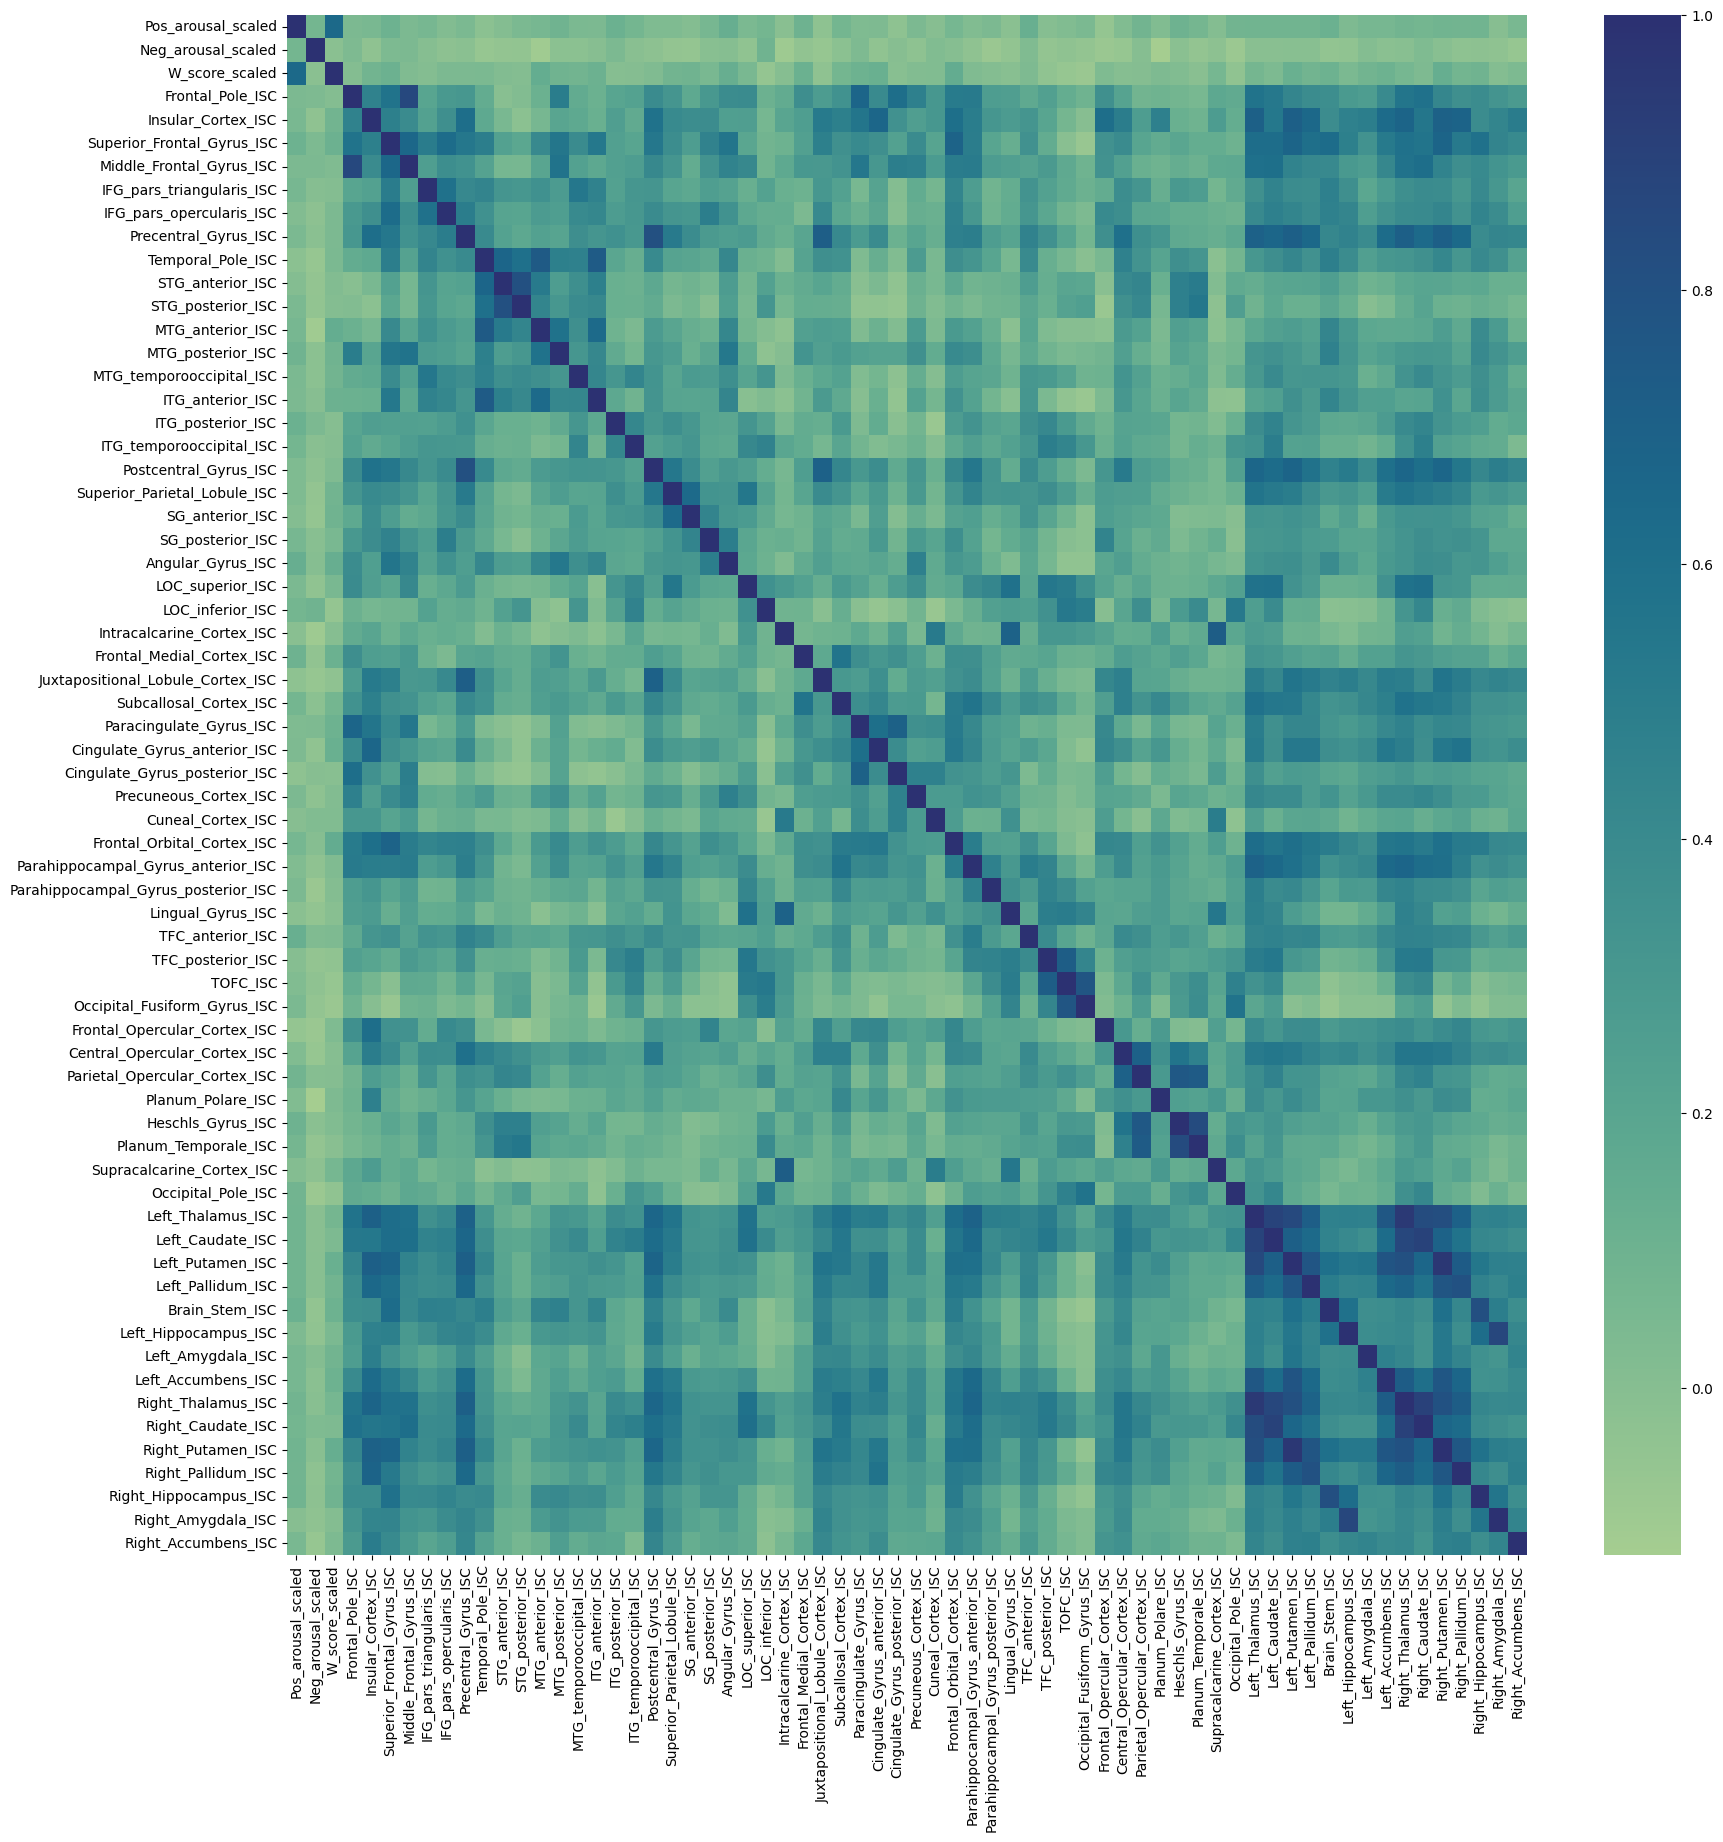

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)

sns.heatmap(all_subjects_isc_comedy_corr, cmap="crest", ax=axs) # , vmin=-0.1

<Axes: >

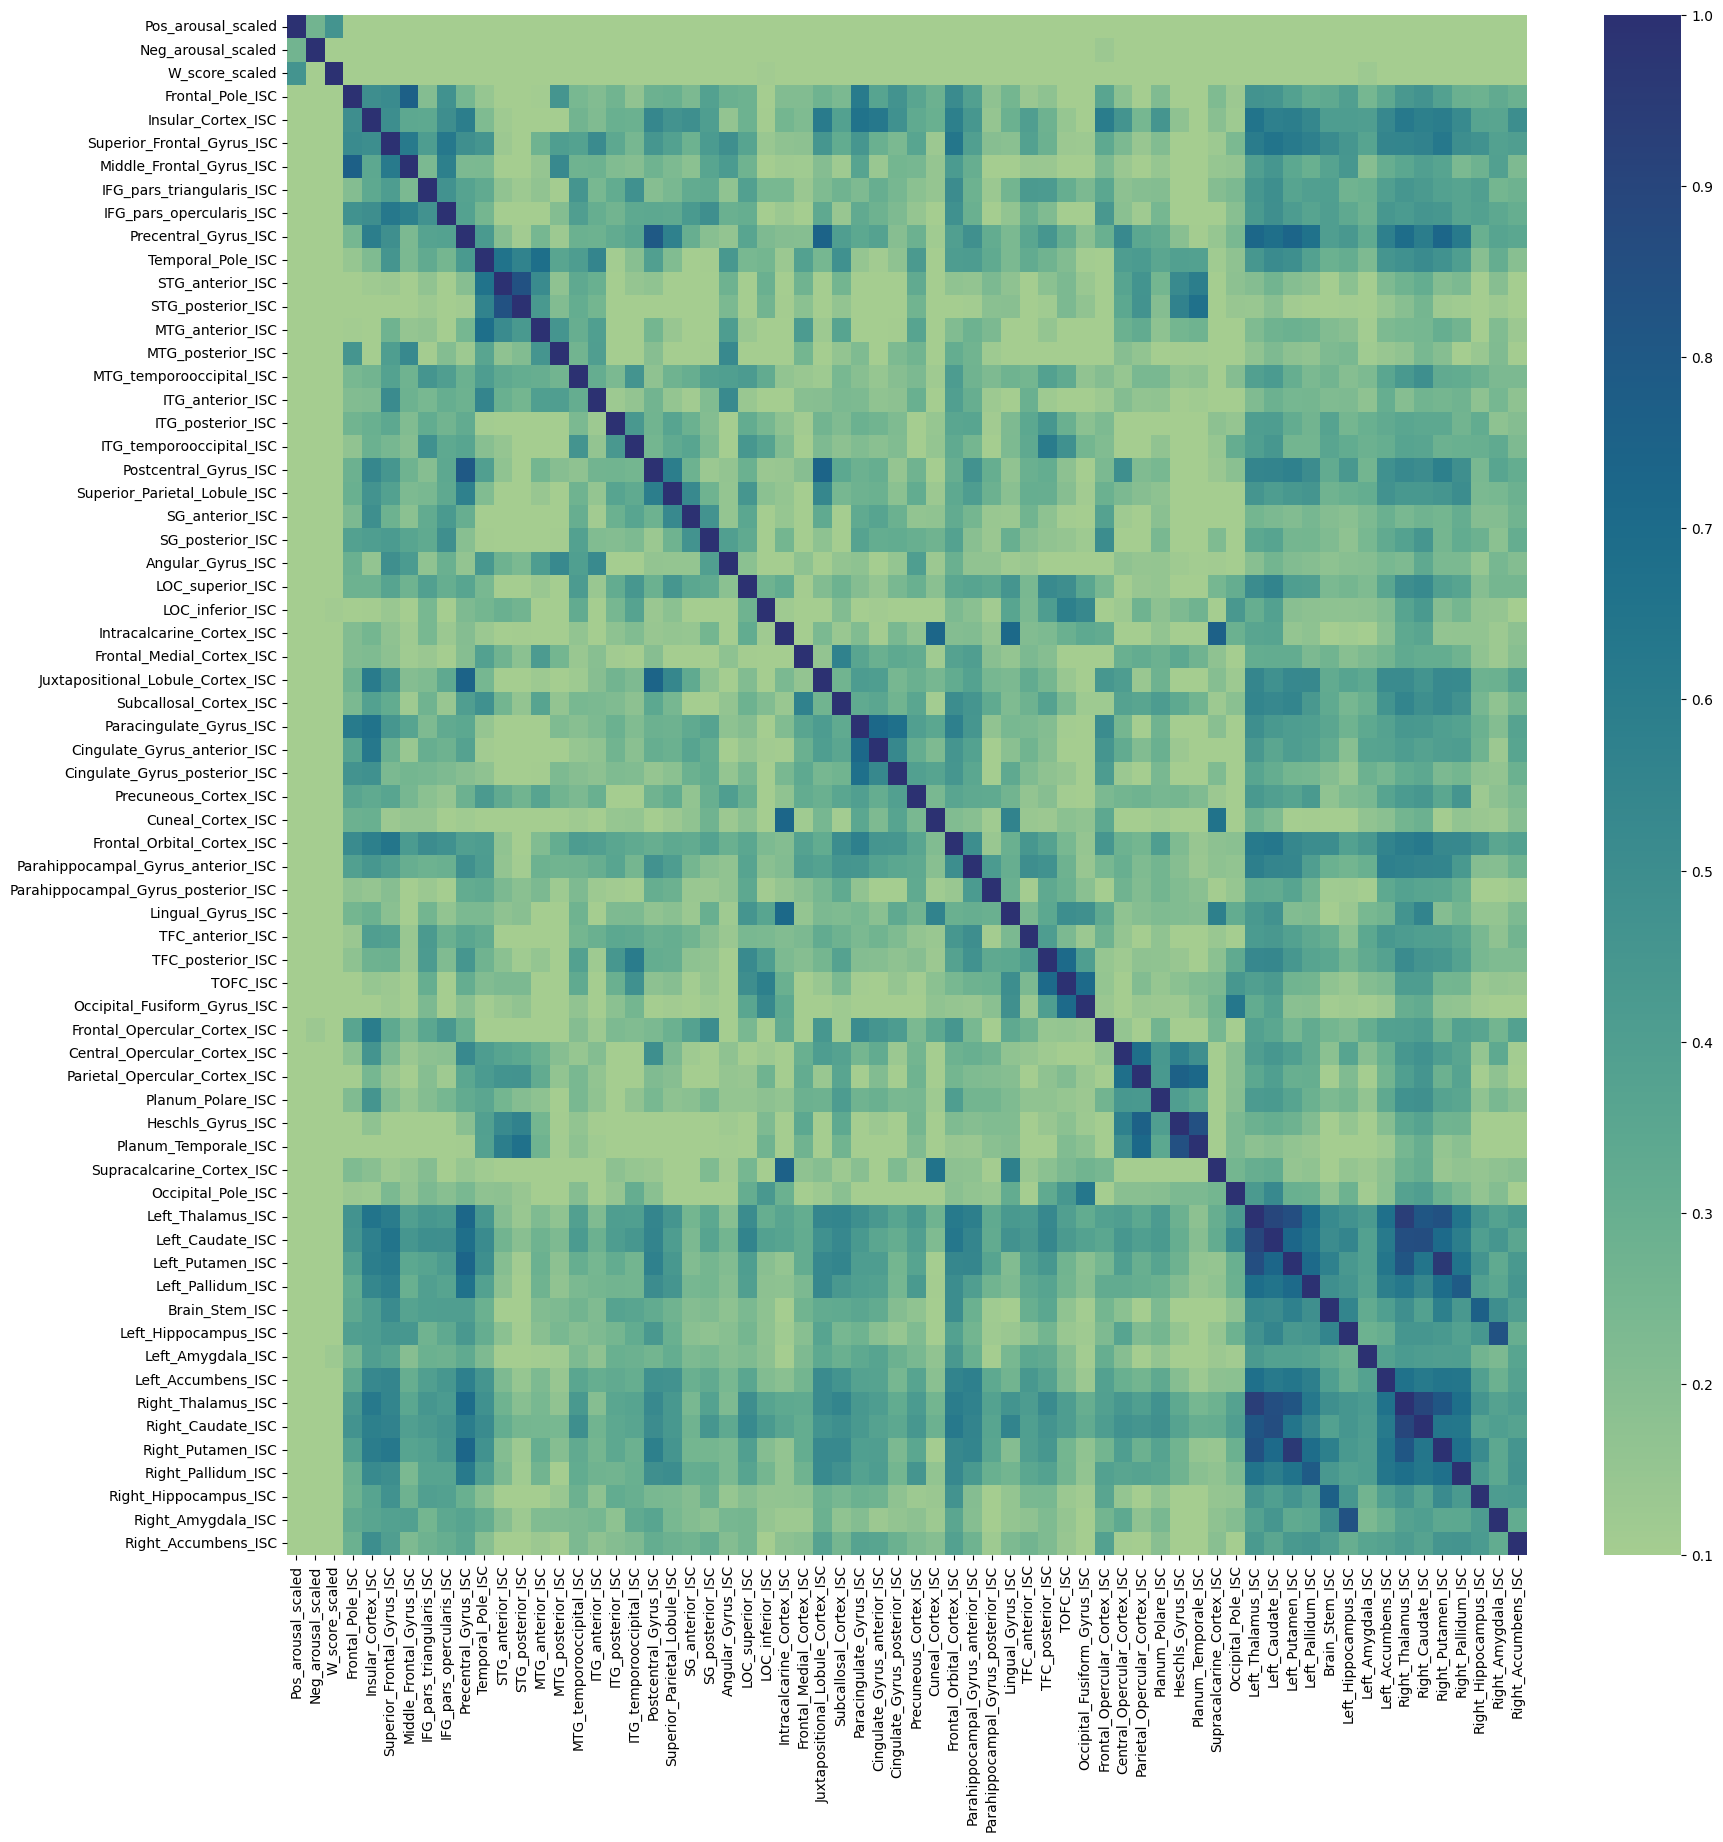

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20), sharex=True)

sns.heatmap(all_subjects_isc_horror_corr, cmap="crest", vmin=0.1, ax=axs)

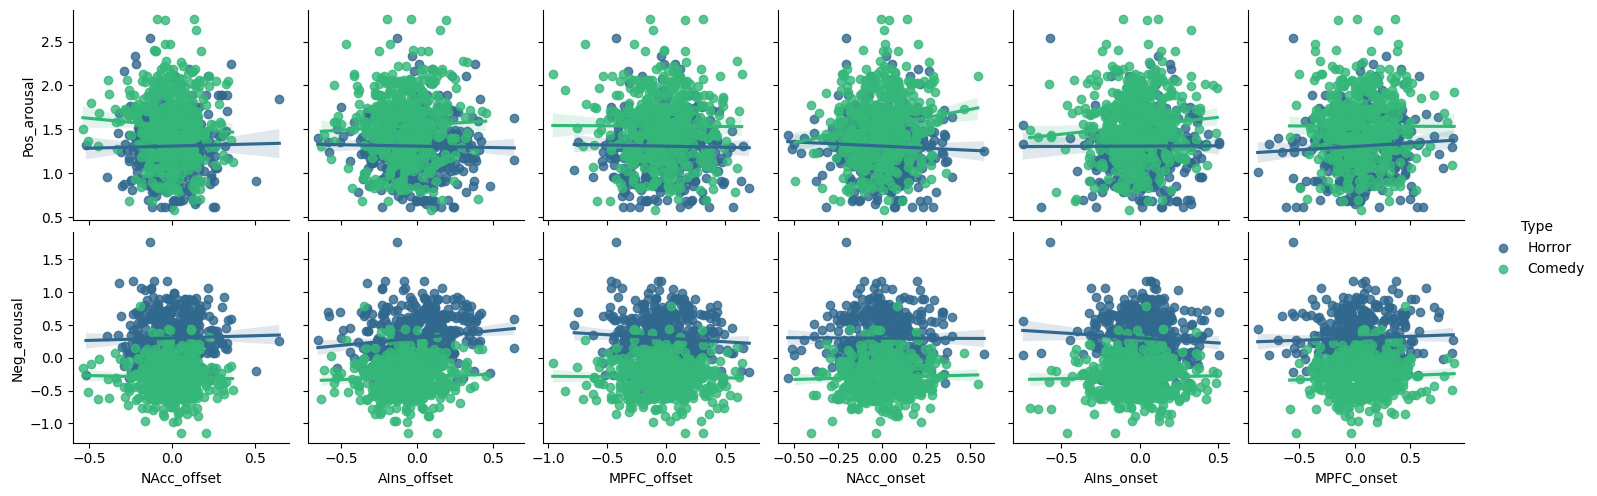

In [ ]:
# Drop outliers from positive arousal. 
all_subs_events_df = all_subs_events_df[all_subs_events_df["Pos_arousal"] < 3]
all_subs_events_df.head()
sns.pairplot(
    all_subs_events_df,
    kind="reg",
    x_vars=["NAcc_offset", "AIns_offset", "MPFC_offset", "NAcc_onset", "AIns_onset", "MPFC_onset"],
    y_vars=["Pos_arousal", "Neg_arousal"], 
    hue="Type",
    palette="viridis")

In [ ]:
all_subs_events_df.keys()

Index(['Participant', 'Trailer', 'Type', 'Onset', 'Offset', 'Duration',
       'W_score', 'A_score', 'F_score', 'NAcc_onset',
       ...
       'MPFC_TR6', 'MPFC_TR7', 'MPFC_TR8', 'MPFC_TR9', 'MPFC_TR10',
       'MPFC_TR11', 'MPFC_TR12', 'MPFC_TR13', 'MPFC_TR14', 'MPFC_TR15'],
      dtype='object', length=104)

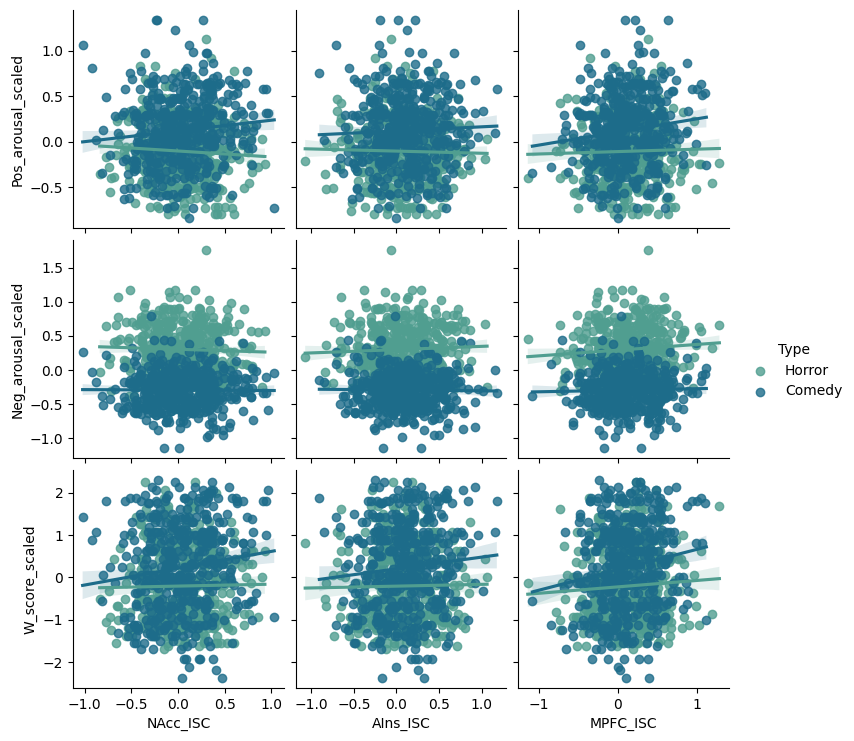

In [ ]:
sns.pairplot(
    all_subs_events_df,
    kind="reg",
    x_vars=["NAcc_ISC", "AIns_ISC", "MPFC_ISC",],
    y_vars=["Pos_arousal_scaled", "Neg_arousal_scaled", "W_score_scaled"], 
    hue="Type",
    palette="crest")

In [ ]:
"""
# Loop through each trailer.
    for id_trailer in current_sub_trailer_keys: 

        # Create empty array to store the timecourses for the current trailer.
        # Accross all participants except the current participant. 
        current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered2), 15))
        current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered2), 15))
        current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered2), 15))

        # Loop through each participant except the current participant.
        for id_sub2 in range(len(participant_list_filtered2)):

            current_sub2 = participant_list_filtered2[id_sub2]

            print(current_sub2)
            # Store the timecourse for the current participant.
            current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_NAcc"]
            current_trailer_timecourses_bAIns[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_AIns"]
            current_trailer_timecourses_bMPFC[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_MPFC"]

        # Calculate the mean timecourse for the group without the current participant.
        mean_timecourse_bNAcc = np.mean(current_trailer_timecourses_bNAcc, axis=0)
        mean_timecourse_bAIns = np.mean(current_trailer_timecourses_bAIns, axis=0)
        mean_timecourse_bMPFC = np.mean(current_trailer_timecourses_bMPFC, axis=0)

        # Calculate the ISC for the current trailer for the current participant.
        # Store correlation value regardless of significance.
        # Note, there is a bit of an improvement when using the last 10 TRs, compared to the whole time course.
        current_sub_timecourses[id_trailer] = {"Bilateral_NAcc": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_NAcc"], mean_timecourse_bNAcc)[0]),
                                               "Bilateral_AIns": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_AIns"], mean_timecourse_bAIns)[0]),
                                               "Bilateral_MPFC": np.arctanh(pearsonr(all_subjects_timecourses_z_dic[current_sub][id_trailer]["Bilateral_MPFC"], mean_timecourse_bMPFC)[0])}
                                              
"""

'\n# Loop through each trailer.\n    for id_trailer in current_sub_trailer_keys: \n\n        # Create empty array to store the timecourses for the current trailer.\n        # Accross all participants except the current participant. \n        current_trailer_timecourses_bNAcc = np.zeros((len(participant_list_filtered2), 15))\n        current_trailer_timecourses_bAIns = np.zeros((len(participant_list_filtered2), 15))\n        current_trailer_timecourses_bMPFC = np.zeros((len(participant_list_filtered2), 15))\n\n        # Loop through each participant except the current participant.\n        for id_sub2 in range(len(participant_list_filtered2)):\n\n            current_sub2 = participant_list_filtered2[id_sub2]\n\n            print(current_sub2)\n            # Store the timecourse for the current participant.\n            current_trailer_timecourses_bNAcc[id_sub2] = all_subjects_timecourses_z_dic[current_sub2][id_trailer]["Bilateral_NAcc"]\n            current_trailer_timecourses_bAIns[id_